## This is the final notebook in a series that explained "Reading the Robot Mind." I hope you'll find it insightful and interesting. 

### NOTE: This notebook uses the outputs of "v16e-gpu-all-birdclef2023-mindreader" (trained CNN) to just perform inference.
Before running, you must use the "Add Data" button, and add all the output of "v16e gpu all birdclef2023 mindreader" (another public notebook with the following direct link: https://www.kaggle.com/code/pnussbaum/v16e-gpu-all-birdclef2023-mindreader)

#### Best Regards, 
#### ---Paul Alton Nussbaum

# Executive Summary
* I coined the term "Reading the Robot Mind" to explain the process of presenting the internal workings of an Artificial Neural Network, or Artificial Intelligence (AI) system, in a way that is intuitive to Subject Matter Experts (SME). 
* The term "explainability" has been used extensively to describe methods that seek to explain how an AI system came to a particular output from a particular input, and can also be useful in troubleshooting.
* Reading the robot mind goes further; allowing SME to see how much information is retained at each layer of the AI system presented in a format familiar to them - even if they are not programmers or are not familiar with the steps in the inference process.
* Reading the robot mind also allows the SME to present hypothetical AI outputs and work backwards through the AI to create an approximation (exemplary) input.
* In this case, SME are folks who can listen to birds or recordings of birds and determine which type of bird is making the sounds. The notebook therefore seeks to provide audio output as well as spectrographic images (both used by bird SME) to the user.
* This is not new (see expired US Patent list at the end of the notebook) nor is it revolutionary. Indeed, this is intuitive for someone testing a microphone and data recording system. They do not want to look at long lists of numbers of recorded data. Instead, they will want to use that data to recreate an approximation of the audio, to listen to the recordings to see if they contain valid and useful information.
* The notebook extends this intuitive and useful technique to individual neural network layers - working backwards towards a best estimate of the original input.
* The user can even provide just the "answer" (select a bird at the final output layer of the AI solution), and the reading the robot mind system will work backwards through the entire automated process and AI layers to let the user hear a best approximation of what it has learned that bird sounds like.
* You may be surprised at what you hear!

# This Notebook and Related Notebooks

As described above, a "reading the robot mind" system can be easily created by simultaneously training auto-encoders along each layer of the network (able to recreate the best approximation of the original input from the data available at that stage of the process). Many shy from this approach because of the added computational cost and time - as competition forces a race to market. I think it is a mistake to skip this step because the training cost is minimal compared to inference costs if the solution is successful. As an example, I cite the currently running Kagle competition where these autoencoders were not trained along with the generative solution, and now there is a scramble to "read the robot mind," (https://www.kaggle.com/competitions/stable-diffusion-image-to-prompts) but there are many other examples, even with in-the-news stories about ChatGPT and the search for inputs that cause toxic or undesired responses.

I have created these notebook to show that it is possible to make a system to read the robot mind, even when those autoencoders were not trained alongside the network. Below is a list of the notebooks related to this one:

* https://www.kaggle.com/code/pnussbaum/v15h-birdclef2023-mindreader - This notebook focuses on the Segmentation and Feature Extraction aspects of the AI solution, allowing users to make modifications (Mel Scal Spectrum, number of resultant frequency bands, MFCC, number of resultant coefficients) and see and hear how much information is retained. It also allows the user to train a simple Convolutional Neural Network (CNN) AI solution and see and hear how much information is retained at each layer - using only a limited number of birds to speed up experimentation. Reading the robot mind learnings include selection of a feature exraction algorithm whereby SME can see and hear that important information has not been discarded, and can also see similarities in feature visualizations (spectrograms) for the same type of birds, while also spotting visual differences between different bird types. The final method used 5 second segments, each converted into an overlapping sequence of 32 Mel Scaled frequency bands.

* https://www.kaggle.com/code/pnussbaum/v15h-all-birdclef2023-mindreader - This notebook allows the user to use their final decision related to segmentation and feature extraction, and convert and save the BirdClef2023 data into this format. It also allows a short amount of training of a CNN on this data; once again, allowing the SME to see and hear how much data is retained at each layer - this time using the entire data set. Learnings include identification of specific layers where important information seems to be discarded. For example, it was noted that the recreation of the input seemed to degrade significantly at certain layers of the network, and so these layers were specifically modified to improve the retention of important information (in the form of additional nerons for dense layers and additional filters for convolutional layers).

* https://www.kaggle.com/code/pnussbaum/v16e-gpu-all-birdclef2023-mindreader - This notebook uses the final decisions noted above, and trains the entire CNN for a longer period of time, achieving better accuracy, and saving the trained AI system. There were several iterations of this notebook, with improvements made based on the reading the robot mind system, but also traditional troubleshooting techniques. An example of one of the traditional AI troubleshooting techniques was the identification of overfitting. This was remediated through the use of data augmentation (shifting the data in time by a small random value during training, etc.)

* The current notebook you are reading - This notebook brings all of this together for the sake of the contest submission, as well as inference analysis and trouleshooting. The notebook lets you hear, visualize, and compare data every step and layer on the way. It allows comparison of samples from the same type of bird (so you can see and hear if they are similar) and different types of birds (so you can see and hear if they are different). Finally, this notebook provides the ability to work backwards through the system from a manually forced output, and let the user see and hear a best estimation of what the trained AI "thinks" that bird type sounds like. Learnings include the ability to hear elements of unique aspects particular to that bird type (short sequences of sound) all mashed together, with a good deal of extraneous noise mixed in.

## Loading the meta data

In [1]:
import pandas as pd

train_meta = pd.read_csv("/kaggle/input/birdclef-2023/train_metadata.csv")
total_data_count = len(train_meta)
print("There are a total of ", total_data_count, "  entries in the dataset")
# Uncomment the below two lines if you wish to see an example nmeta data entry.
# print("Here is the first entry in the dataset metadata:\n")
# print(train_meta.iloc[0])


There are a total of  16941   entries in the dataset


In [2]:
# Create a list of all the possible classifications (labels)
labels = list(train_meta['primary_label'].unique())
print("There are ", len(labels), " different labels in the whole dataset.\n")
num_birds = len(labels)
epochs = 16
pre_trained = True


There are  264  different labels in the whole dataset.



In [3]:
image_data = []
for label in labels : 
    image_data.append(train_meta[train_meta["primary_label"] == label].iloc[:])
image_data = pd.concat(image_data).reset_index(drop=True) 
total_image_data_count = len(image_data)
print("There are ", total_image_data_count, " different entries in the image data set.\n")

There are  16941  different entries in the image data set.



## Helper functions to transform and untransform (reverse transform) and save resultant features

In [4]:
# These functions will help transform and untransform (reverse transformation) as well as
# reducing the resolution of floating point feature values into 8-bit unsigned integers.
# The goal is to convert each 5 second segment of auio into a 2D greyscale image of 8-bit uints.
# After this is done, we can use these images as inputs to our classifier.

import librosa 
import numpy as np
from PIL import Image
import os
import soundfile as sf

# These are the features to be extracted, as was decided from earlier notebook experiments
use_mfcc = False # otherwise use Mel Spectrogram
n_mels = 32 # used for both Mel Spectrogram and MFCC
n_coeff = 1 # number of cepstral coefficients (only used for MFCC)

# Image dimensions
if use_mfcc :
    if n_coeff < n_mels :
        num_rows = n_coeff 
    else :
        num_rows = n_mels
else :
    num_rows = n_mels
    
num_columns = 313 # number of MFCC frames generated from 160000 samples of sudio (5 sec at 32000)
num_channels = 1

# MAY BE A MISTAKE TO MAKE THIS A GLOBAL VALUE - but it's always forced to 32000
sr = 32000 # default sampling rate if none provided

Window_Size = 5 # 5 seconds
# Get number of samples for 5 seconds
segment = Window_Size * sr


def Audio_to_Domain(y, sr):
    if use_mfcc:
        feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coeff, n_mels=n_mels, power=3) # raise to 3rd power before extracting coefficients to reduce noise
    else :
        feat = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, power=1)
    if feat.shape[1] <= num_columns:
        pad_width = num_columns - feat.shape[1]
        feat = np.pad(feat, pad_width=((0,0),(0,pad_width)), mode='constant')
    return feat

def Domain_to_Audio(feat, sr):
    if use_mfcc :
        y = librosa.feature.inverse.mfcc_to_audio(feat, sr=sr, n_mels=n_mels, power=3)
    else :
        y = librosa.feature.inverse.mel_to_audio(feat, sr=sr, power=1) 
    return y


def Audio_Segment_Transform_and_Save(file_path, cat_name='dummy', is_save=True, train=True, sr=sr):

    # First load the file
    filename = file_path.replace("/", "_")
    file_path = "/kaggle/input/birdclef-2023/train_audio/" + file_path
    audio, sr = librosa.load(file_path, sr = sr)

    # Get number of samples for 5 seconds
    buffer = segment

    samples_total = len(audio)
    samples_wrote = 0
    counter = 1

    # this will be a list of 5 second segments
    feature_split = []
    # each segment will have its own filename
    feature_filenames = []
    # each segment will also have its own min and range value for reconstruction (reverse transformation)
    feature_mins = []
    feature_ranges = []
    while samples_wrote < samples_total:
        #check if the buffer is not exceeding total samples 
        if buffer > (samples_total - samples_wrote):
            buffer = samples_total - samples_wrote

        block = audio[samples_wrote : (samples_wrote + buffer)]
        these_features = Audio_to_Domain(block, sr)
        feature_split.append(these_features)

        # Write Window_Size second segment
        if is_save == True:
            # had to add the letter "z" in front of my output files and paths, becuase contest submission searches output files alphabetically (!?)
            out_filename = "/kaggle/working/zimages/" + cat_name + \
                "/split_" + str(counter) + "_" + filename + ".png"
            
            feature_filenames.append(out_filename)
            
            # convert the features into an image for saving
            
            #scale to 0 - 255
            fmax = these_features.max()
            fmin = these_features.min()
            frange = fmax - fmin
            # these_features = 255 * ((these_features - fmin)/frange)
            these_features = np.array((((these_features - fmin) / frange)*255), dtype='uint8')
            # save the min and range for later reconstruction (reverse transform, or un-transform) back to audio
            feature_mins.append(fmin)
            feature_ranges.append(frange)
            this_image = Image.fromarray(these_features, mode = 'L')
            # make the directory if it doesn't yet exist
            if not os.path.exists(os.path.dirname(out_filename)):
                try:
                    os.makedirs(os.path.dirname(out_filename))
                except OSError as exc: # Guard against race condition
                    if exc.errno != errno.EEXIST:
                        raise            
            # save the file
            this_image.save(out_filename, format="PNG")
            
        counter += 1
        samples_wrote += buffer
    return feature_split, sr, feature_filenames, feature_mins, feature_ranges

def Load_and_UnTransform(filename):
    this_image = Image.open(filename)
    block = Domain_to_Audio(this_image, sr)
    return block, sr
    

def Save_Features(_df, train=True):
    data = []
    
    # When importing directories, we use the "input" folder instead of the "working" folder

    if os.path.exists(os.path.dirname("/kaggle/input/v16e-gpu-all-birdclef2023-mindreader/zimages/")):  # was "working" instead of "input/v16e-gpu-all-birdclef2023-mindreader"
        print("WARNING: Image files already saved. Aborting save to avoid corrupted image databse.")
        data_df = pd.DataFrame(data, columns=['primary_label', 'original_filename', 'filename', 'fmin', 'frange'])
        # had to add the letter z in front of filenames and paths so competition submission can find the output file (alphabetically)
        data_df = pd.read_csv("/kaggle/input/v16e-gpu-all-birdclef2023-mindreader/zimages.csv")  # was "working" instead of "input/v16e-gpu-all-birdclef2023-mindreader"
    else:
        for index, row in _df.iterrows(): # was tqdm(_df.iterrows()):
            audio_lst, sr, filenames, mins, ranges = Audio_Segment_Transform_and_Save(row["filename"], cat_name = row["primary_label"], is_save = True, train = train)
            for idx, y in enumerate(audio_lst):
                data.append([row["primary_label"], row["filename"], filenames[idx], mins[idx], ranges[idx]])
    
        data_df = pd.DataFrame(data, columns=['primary_label', 'original_filename', 'filename', 'fmin', 'frange'])
        data_df.to_csv("/kaggle/working/zimages.csv", index=False)

    return data_df
    
    


# See and Hear the Feature Extraction
#### Try a number of Feature Extraction Algorithms and test the following:
* Do the features visually look similar for the same bird, and different for different birds?
* Is the similarity/difference enough to be able to visually classify which bird is which?
* What about the audio - is the recreated sound clear enough for an expert to identify the bird?
* If the answer is "no" to any of the above, allow fine tuning by the user (three different feature extractions are compared below)

In [5]:
# Visually examine feature extraction algorithms
import IPython
import matplotlib.pyplot as plt

def Compare_Feature_Extraction(image_data, list_to_compare) :
    global sr, segment
    list_len = len(list_to_compare)
    if list_len < 2 :
        print("Must provide at least 2 items - cannot compare.\n")
        return()
    else:
        plt.figure(figsize=(10, 10))
        for i in range(list_len):
            # grab from the image set
            audio_filename = image_data.at[list_to_compare[i],"filename"]
            common_name = image_data.at[list_to_compare[i],"common_name"]
            # load the audio data
            audio, sr = librosa.load("/kaggle/input/birdclef-2023/train_audio/" + audio_filename, sr = sr)
            # Take first 5 second "segment"
            audio = audio[0:segment]
            # Extract the feaures
            feat = Audio_to_Domain(audio, sr)
            # Move the range from current min and max, into 0 to 255 8 bit integers
            fmin = feat.min()
            fmax = feat.max()
            frange = fmax - fmin
            feat = np.array((((feat - fmin) / frange)*255), dtype='uint8')
            # Plot the features
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(feat, cmap='gray', aspect=(num_columns/num_rows), interpolation = 'None')
#            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray', aspect=(num_columns/num_rows), interpolation = 'None')
            plt.title(common_name)
            plt.axis("off")
    return()


Compare features from the SAME birds (first 5 sec of audio used)



()

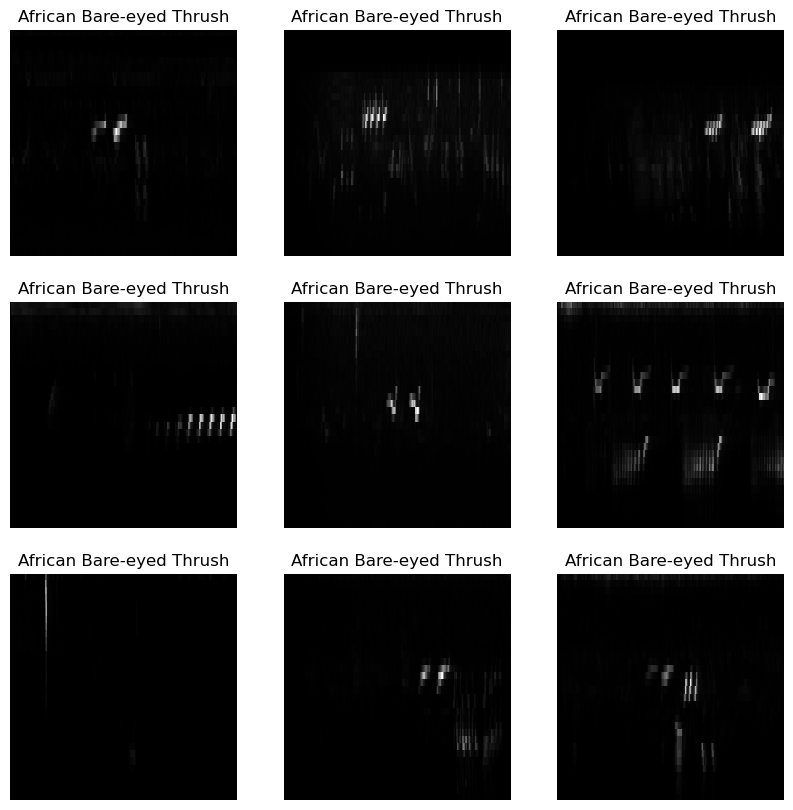

In [6]:
print("Compare features from the SAME birds (first 5 sec of audio used)\n")            
# Compare the first 10 entries in the image_data
Compare_Feature_Extraction(image_data, [0, 1, 2, 3, 4, 5, 6, 7, 8])

### The above shows extracted features for sounds samples from the same bird
* Comparing features from the same bird now yields more similarities
* Seems like now we have plenty of information (maybe too much? Will it slow down our training algorithm or cause it to overfit?)

Compare features from the DIFFERENT birds (first 5 sec of audio used)



()

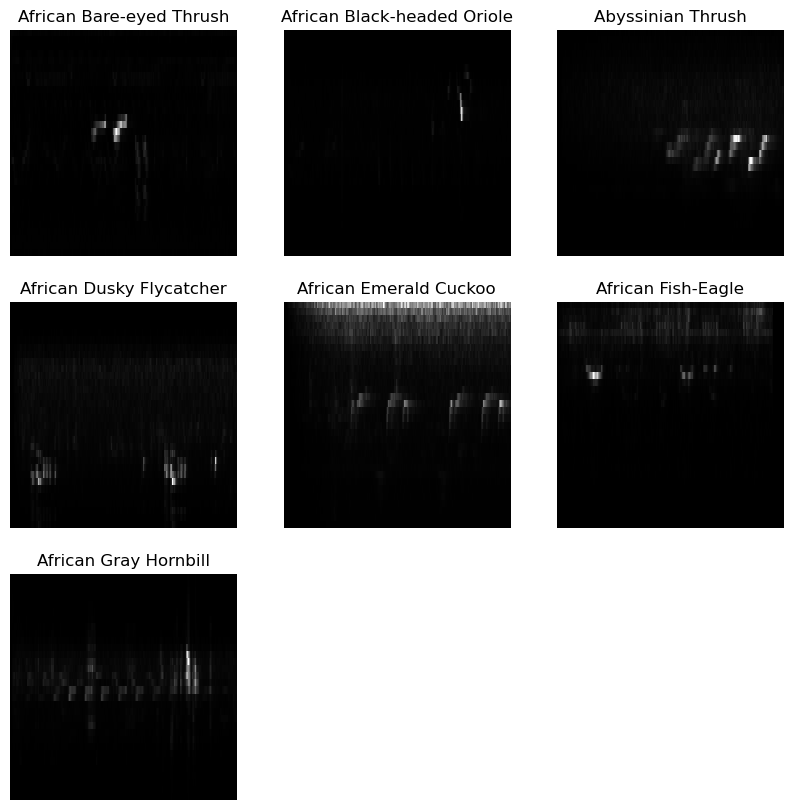

In [7]:
print("Compare features from the DIFFERENT birds (first 5 sec of audio used)\n")            
# Compare the first 10 entries in the image_data
Compare_Feature_Extraction(image_data, [0, 50, 150, 200, 225, 350, 430])

### The above shows extracted features for sounds samples from DIFFERENT birds
* Different birds indeed seem to have different features, but also instantaneous similarities (which may be differentiated as they change over time). 
* "Different versus similar" birds start to make itself more visible, but with regard to that time window, it looks like 1.5 to 2 seconds of changing notes might be needed to differentiate birds (since there are 313 samples in a 5 second window, this equates to 95 to 125 feature vectors.
* Still not sure if a bird expert would use these images to classify birds.

## Let's listen to the untransformation (recreate audio from the extracted features)
* We'll only listen to the first segment from the first bird

In BLUE is the original audio of the first segment of the first audio file

Superimposed in ORANGE the RECREATED (un-transformed) audio of the first segment of the first image file

This is the audio playback of the ORIGINAL audio file


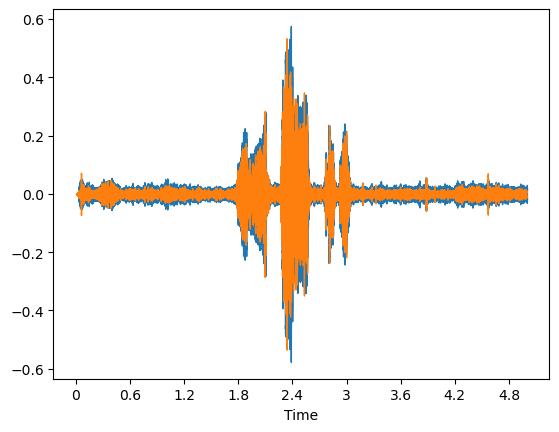

In [8]:
audio_filename = image_data.at[0,"filename"]
common_name = image_data.at[0,"common_name"]
# load the audio data
audio, sr = librosa.load("/kaggle/input/birdclef-2023/train_audio/" + audio_filename, sr = sr)
# Take first 5 second "segment"
audio = audio[0:segment]
# Extract the feaures
feat = Audio_to_Domain(audio, sr)
# Move the range from current min and max, into 0 to 255 8 bit integers
fmin = feat.min()
fmax = feat.max()
frange = fmax - fmin
feat = np.array((((feat - fmin) / frange)*255), dtype='uint8')
# Go back to the original range of values
feat = ((feat/255)*frange)+fmin
# Recreate the audio from the extracted features
recreated_audio = Domain_to_Audio(feat, sr)

print("In BLUE is the original audio of the first segment of the first audio file\n")
librosa.display.waveshow(audio, sr=sr)

print("Superimposed in ORANGE the RECREATED (un-transformed) audio of the first segment of the first image file\n")
librosa.display.waveshow(recreated_audio, sr=sr)

print("This is the audio playback of the ORIGINAL audio file")
IPython.display.Audio(data = audio, rate=sr)

In [9]:
print("This is the audio playback of the RECREATED audio file")
IPython.display.Audio(data = recreated_audio, rate=sr)

This is the audio playback of the RECREATED audio file


## The above lets us listen to recreation of the original input from the Extracted Features## The above showed
* The audio is definitely more clear
* It seems obvious that "a human expert will be able to use the RECREATED audio to correctly classify birds."
* Naturally, if they couuld perform the classification with the raw audio
* Segmentation is still the open question - if the 5 second window does not containt enough of that bird's call, etc...

# Build Convolutional Neural Network
## Build a simple CNN to perform classification
* Use sequences of Conv2D and MaxPool to find edges, textures, and patterns
* NOTE: You can change Conv2D filter counts and shapes, as well as MaxPool2D shapes, but if you add or remove layers, you'll need to modify the backwards process (manually coded later in the notebook) as I have not yet implemented a method that figures out the layer structure automatically.

In [10]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Concatenate, Activation
from keras.layers import Dropout,BatchNormalization, Input, Rescaling, RandomTranslation, GaussianDropout

inputs = Input(shape = (num_rows, num_columns, 1))

# Rescale the input (arrives as 0-255 8-bit uint grayscale pixels)
model = Rescaling(1./255)(inputs)
### Added image augmentation by shifting input left or right by 20% (1 second) and filling with 0's
model = RandomTranslation(0, .2, fill_mode="constant", fill_value=0.0,)(model)
### Added multiplicative (10%) 1-centered gaussian noise for data augmentation
model = GaussianDropout(0.1)(model)

# This model has a sequential set of Conv2D and MaxPool layers finished with a 32 Dense 
# In this way, the model seeks to embed the entire image into a 32 dim vector
model1 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)   # was 32 filters
model1 = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)  # was 32 filters
model1 = MaxPool2D(pool_size=(2, 2))(model1)

model1a = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model1) # was 64 filters
model1a = Dropout(0.2)(model1a)
model1a = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model1a)# was 32 filters
model1a = Dropout(0.2)(model1a)

model1b = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model1a)# was 32 filters
model1b = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model1b)# was 32 filters
# Lets compress the time down
model1b = MaxPool2D(pool_size=(2, 2))(model1b)

model1c = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model1b)# was 64 filters

# Flatten and use Dense to find a lower dim embedding
model1c = Flatten()(model1c)
model1c = Dense(128, activation = "relu")(model1c)

bird_classification = Dense(num_birds, activation = 'softmax')(model1c)

model = Model(inputs=inputs, outputs=bird_classification)

In [11]:
###########################################################################################
# If the user changes the layers of the network, below parameters must also be changed    #
###########################################################################################
# NOTE This is manually configured. Need to make this automated.
num_conv = 7 # number of convolutional layers
conv_layer = [4, 5, 7, 9, 11, 12, 14] # the layer (counting from layer 0, the input layer) of the Conv2D's'
flatten_layer = 15
embed_layer = 16   # The first Dense layer after the Flatten
class_layer = 17   # The last Dense layer (with Softmax Activation) that determines the final classification
scale_size = [1, 1, 2, 1, 1, 2, 1] # any scaling (due to strides or max pooling) that took place just prior to or at that conv layer (not cumulative)
###########################################################################################
# If the user changes the layers of the network, above parameters must also be changed    #
###########################################################################################

#######################################################################################################################
# If changing the shape of the last convolutional later or embed layer, please also change this next lines            #
# Sorry this is hard coded. Need to make it autoconfigured.                                                           #
#######################################################################################################################
pre_flatten = (8, 78, 256, 128)   
into_flatten = (8, 78, 256)


## Here you can see the Model Summary

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 313, 1)]      0         
                                                                 
 rescaling (Rescaling)       (None, 32, 313, 1)        0         
                                                                 
 random_translation (RandomT  (None, 32, 313, 1)       0         
 ranslation)                                                     
                                                                 
 gaussian_dropout (GaussianD  (None, 32, 313, 1)       0         
 ropout)                                                         
                                                                 
 conv2d (Conv2D)             (None, 32, 313, 64)       640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 313, 128)      73856 

## Here you can see the architecture of the model

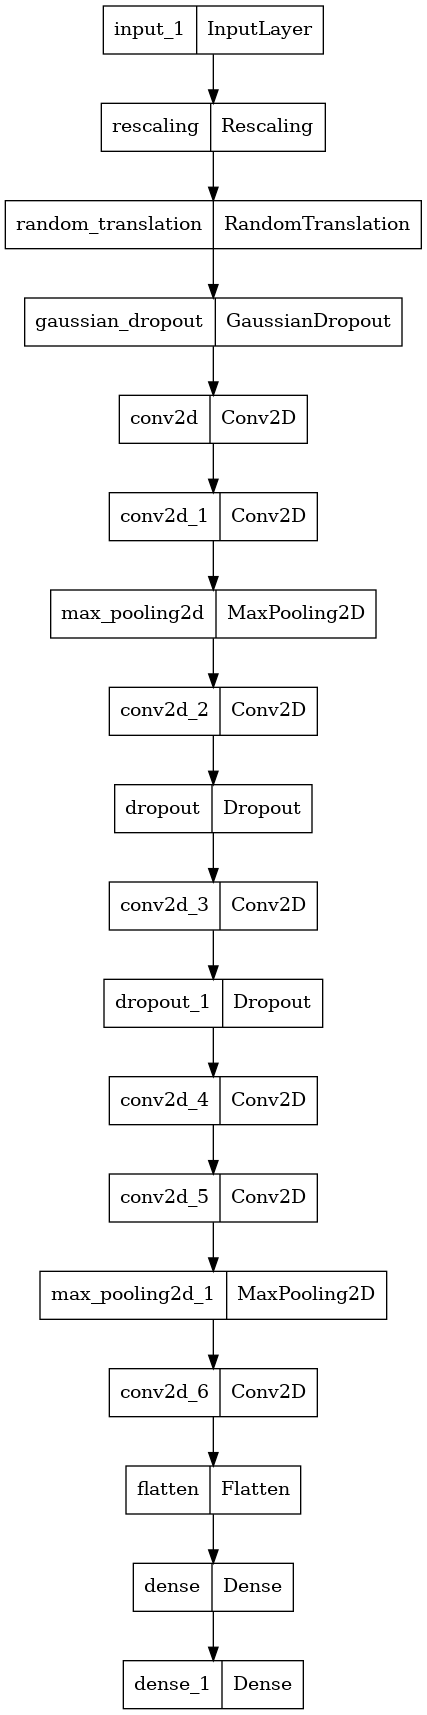

In [13]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

# Load the Trained CNN


In [14]:
if os.path.exists(os.path.dirname("/kaggle/input/v16e-gpu-all-birdclef2023-mindreader/zclassifier/")):  # was "working" instead of "input/v16e-gpu-all-birdclef2023-mindreader"
    print("WARNING: Trained CNN already saved. Aborting training to avoid corrupted CNN.")
    checkpoint_model_path = "/kaggle/input/v16e-gpu-all-birdclef2023-mindreader/zclassifier"
    model = keras.models.load_model(checkpoint_model_path)
    pre_trained = True
else:
    print(" ERROR - Missing trained CNN weights. You must ADD DATA from v16e-gpu-all-birclef2023-mindreader before running this notebook.\n")

# Examine the CNN Filters
## Visualize each layer of the trained CNN
* We wish to examine the trained CNN model. In particular, we will be looking to see if we have too many (redundant) convolutional filters, or if there are other issues that can be discerened by looking into the trained CNN.
* We will do this by traversing the internal workings of the trained CNN weights.

In [15]:
model_explore = [] # list of models that stop at each convolutional layer
Conv2D_weights = [] # list of filters for convolutional layer
Conv2D_biases = [] # list of filter biases for convolutional layer

for i in range (num_conv):
    conv_ind = conv_layer[i]
    print("Conv2D ", i, "occurs at layer",conv_ind)
    model_explore.append(Model(inputs=model.inputs, outputs=model.get_layer(index=conv_ind).output))
    print("Including prior layers, will get an Input Shape of:",model_explore[i].input_shape)
    print("and have an Output Shape of:",model_explore[i].output_shape )
    Conv2D_weights.append(np.copy(model.get_layer(index=conv_ind).get_weights()[0]))
    Conv2D_biases.append(np.copy(model.get_layer(index=conv_ind).get_weights()[1]))
    # These are the filters
    print("Final Conv2D has the following rows, columns, color depth, number of filters", Conv2D_weights[i].shape)
    # These are the biases
    print("and bias for each filter", Conv2D_biases[i].shape)
    print("------------------------")

model_flatten = Model(inputs=model.inputs, outputs=model.get_layer(index=flatten_layer).output)
model_embed = Model(inputs=model.inputs, outputs=model.get_layer(index=embed_layer).output)
model_class = Model(inputs=model.inputs, outputs=model.get_layer(index=class_layer).output)

Conv2D  0 occurs at layer 4
Including prior layers, will get an Input Shape of: (None, 32, 313, 1)
and have an Output Shape of: (None, 32, 313, 64)
Final Conv2D has the following rows, columns, color depth, number of filters (3, 3, 1, 64)
and bias for each filter (64,)
------------------------
Conv2D  1 occurs at layer 5
Including prior layers, will get an Input Shape of: (None, 32, 313, 1)
and have an Output Shape of: (None, 32, 313, 128)
Final Conv2D has the following rows, columns, color depth, number of filters (3, 3, 64, 128)
and bias for each filter (128,)
------------------------
Conv2D  2 occurs at layer 7
Including prior layers, will get an Input Shape of: (None, 32, 313, 1)
and have an Output Shape of: (None, 16, 156, 128)
Final Conv2D has the following rows, columns, color depth, number of filters (5, 5, 128, 128)
and bias for each filter (128,)
------------------------
Conv2D  3 occurs at layer 9
Including prior layers, will get an Input Shape of: (None, 32, 313, 1)
and hav

## Create multiple sub-CNN networks
* Each network will be identical to the original trained network, except the output layer will be one of the Conv2D layers
* We want to input an image (in this case, features extracted from audio bird calls, transformed into an 8 bit resolution grayscale image) and output the results of that last Conv2D layer.
* From this intermediate output, we will work backwards through the CNN and attempt to recreate the original image (later in this notebook).
* We will also use these sub-networks to visualize the CNN filters as described above.

In [16]:
# PANv12f now we use a list of models that can be traversed.
for conv_l in range(num_conv):
    print("Overall Explore ",conv_l," Model Summary:", model_explore[conv_l].summary(), "\n")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 313, 1)]      0         
                                                                 
 rescaling (Rescaling)       (None, 32, 313, 1)        0         
                                                                 
 random_translation (RandomT  (None, 32, 313, 1)       0         
 ranslation)                                                     
                                                                 
 gaussian_dropout (GaussianD  (None, 32, 313, 1)       0         
 ropout)                                                         
                                                                 
 conv2d (Conv2D)             (None, 32, 313, 64)       640       
                                                                 
Total params: 640
Trainable params: 640
Non-trainable param

## Let's observe the internal models of the CNN visually
* Each convolution filter has weights that form the pattern "it is looking for." 
* More specifically, image areas that most closely match the weights of the convolutional filter will yield a higher numerical value when convolved (multiplied) by that filter.
* When MaxPooling, it is these most closely matching parts of the image that will have maximal values, and therefore remain, while other, less closely matching portions of the image will be thrown away since they will vield lower convolution values.
* In this way we can visualize the types of image pixel groupings each CNN filter "is looking for."
* When multiple CNN layers are connected in sequence, the last layer receives a CNN value from multiple filters in the prior layer. Here too, the last CNN layer is "looking for" combinations of prior layer CNN filter convolution results. We can literally combine those prior CNN layer visualizations to form a visualization for each of the last CNN layer filters.
* In this way, we build up visualizations of what each filter of each CNN layer "is looking for." 
* Layers like Droput are ignored in this analysis
* Layers like MaxPooling are handled with a scaling factor
### NOTE: Similar to the "expansion" method shown here https://distill.pub/2020/circuits/visualizing-weights/

Show the reconstructed image patch for each filter of convolutional layer  0 which occured at layer  4 in the original model
Conv Layer 0  filter Size: 3  x  3  and border size (padding) of  1  and cumulative border from prior layers of  0


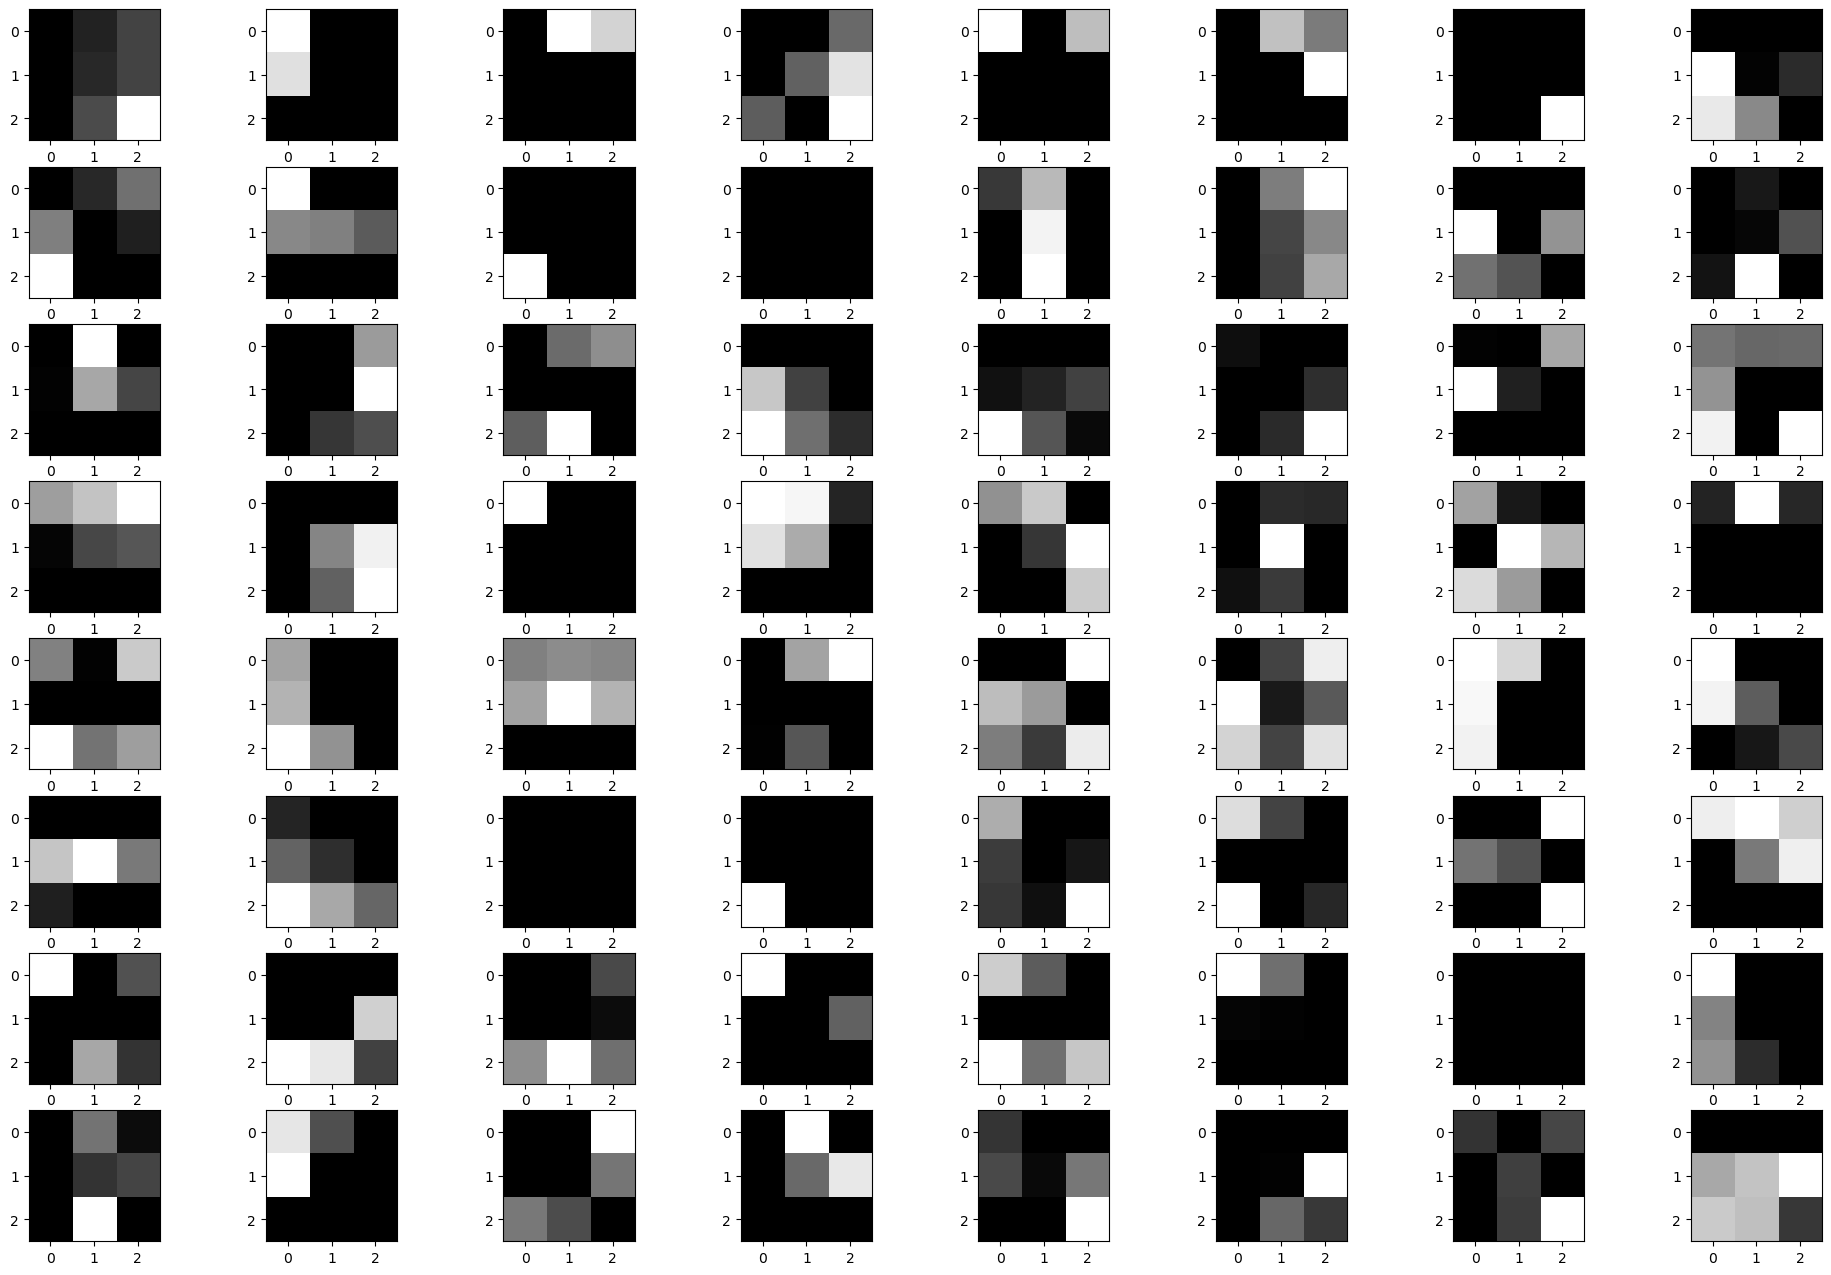

Show the reconstructed image patch for each filter of convolutional layer  1 which occured at layer  5 in the original model
Conv Layer 1  filter Size: 3  x  3  and border size (padding) of  1  and cumulative border from prior layers of  1


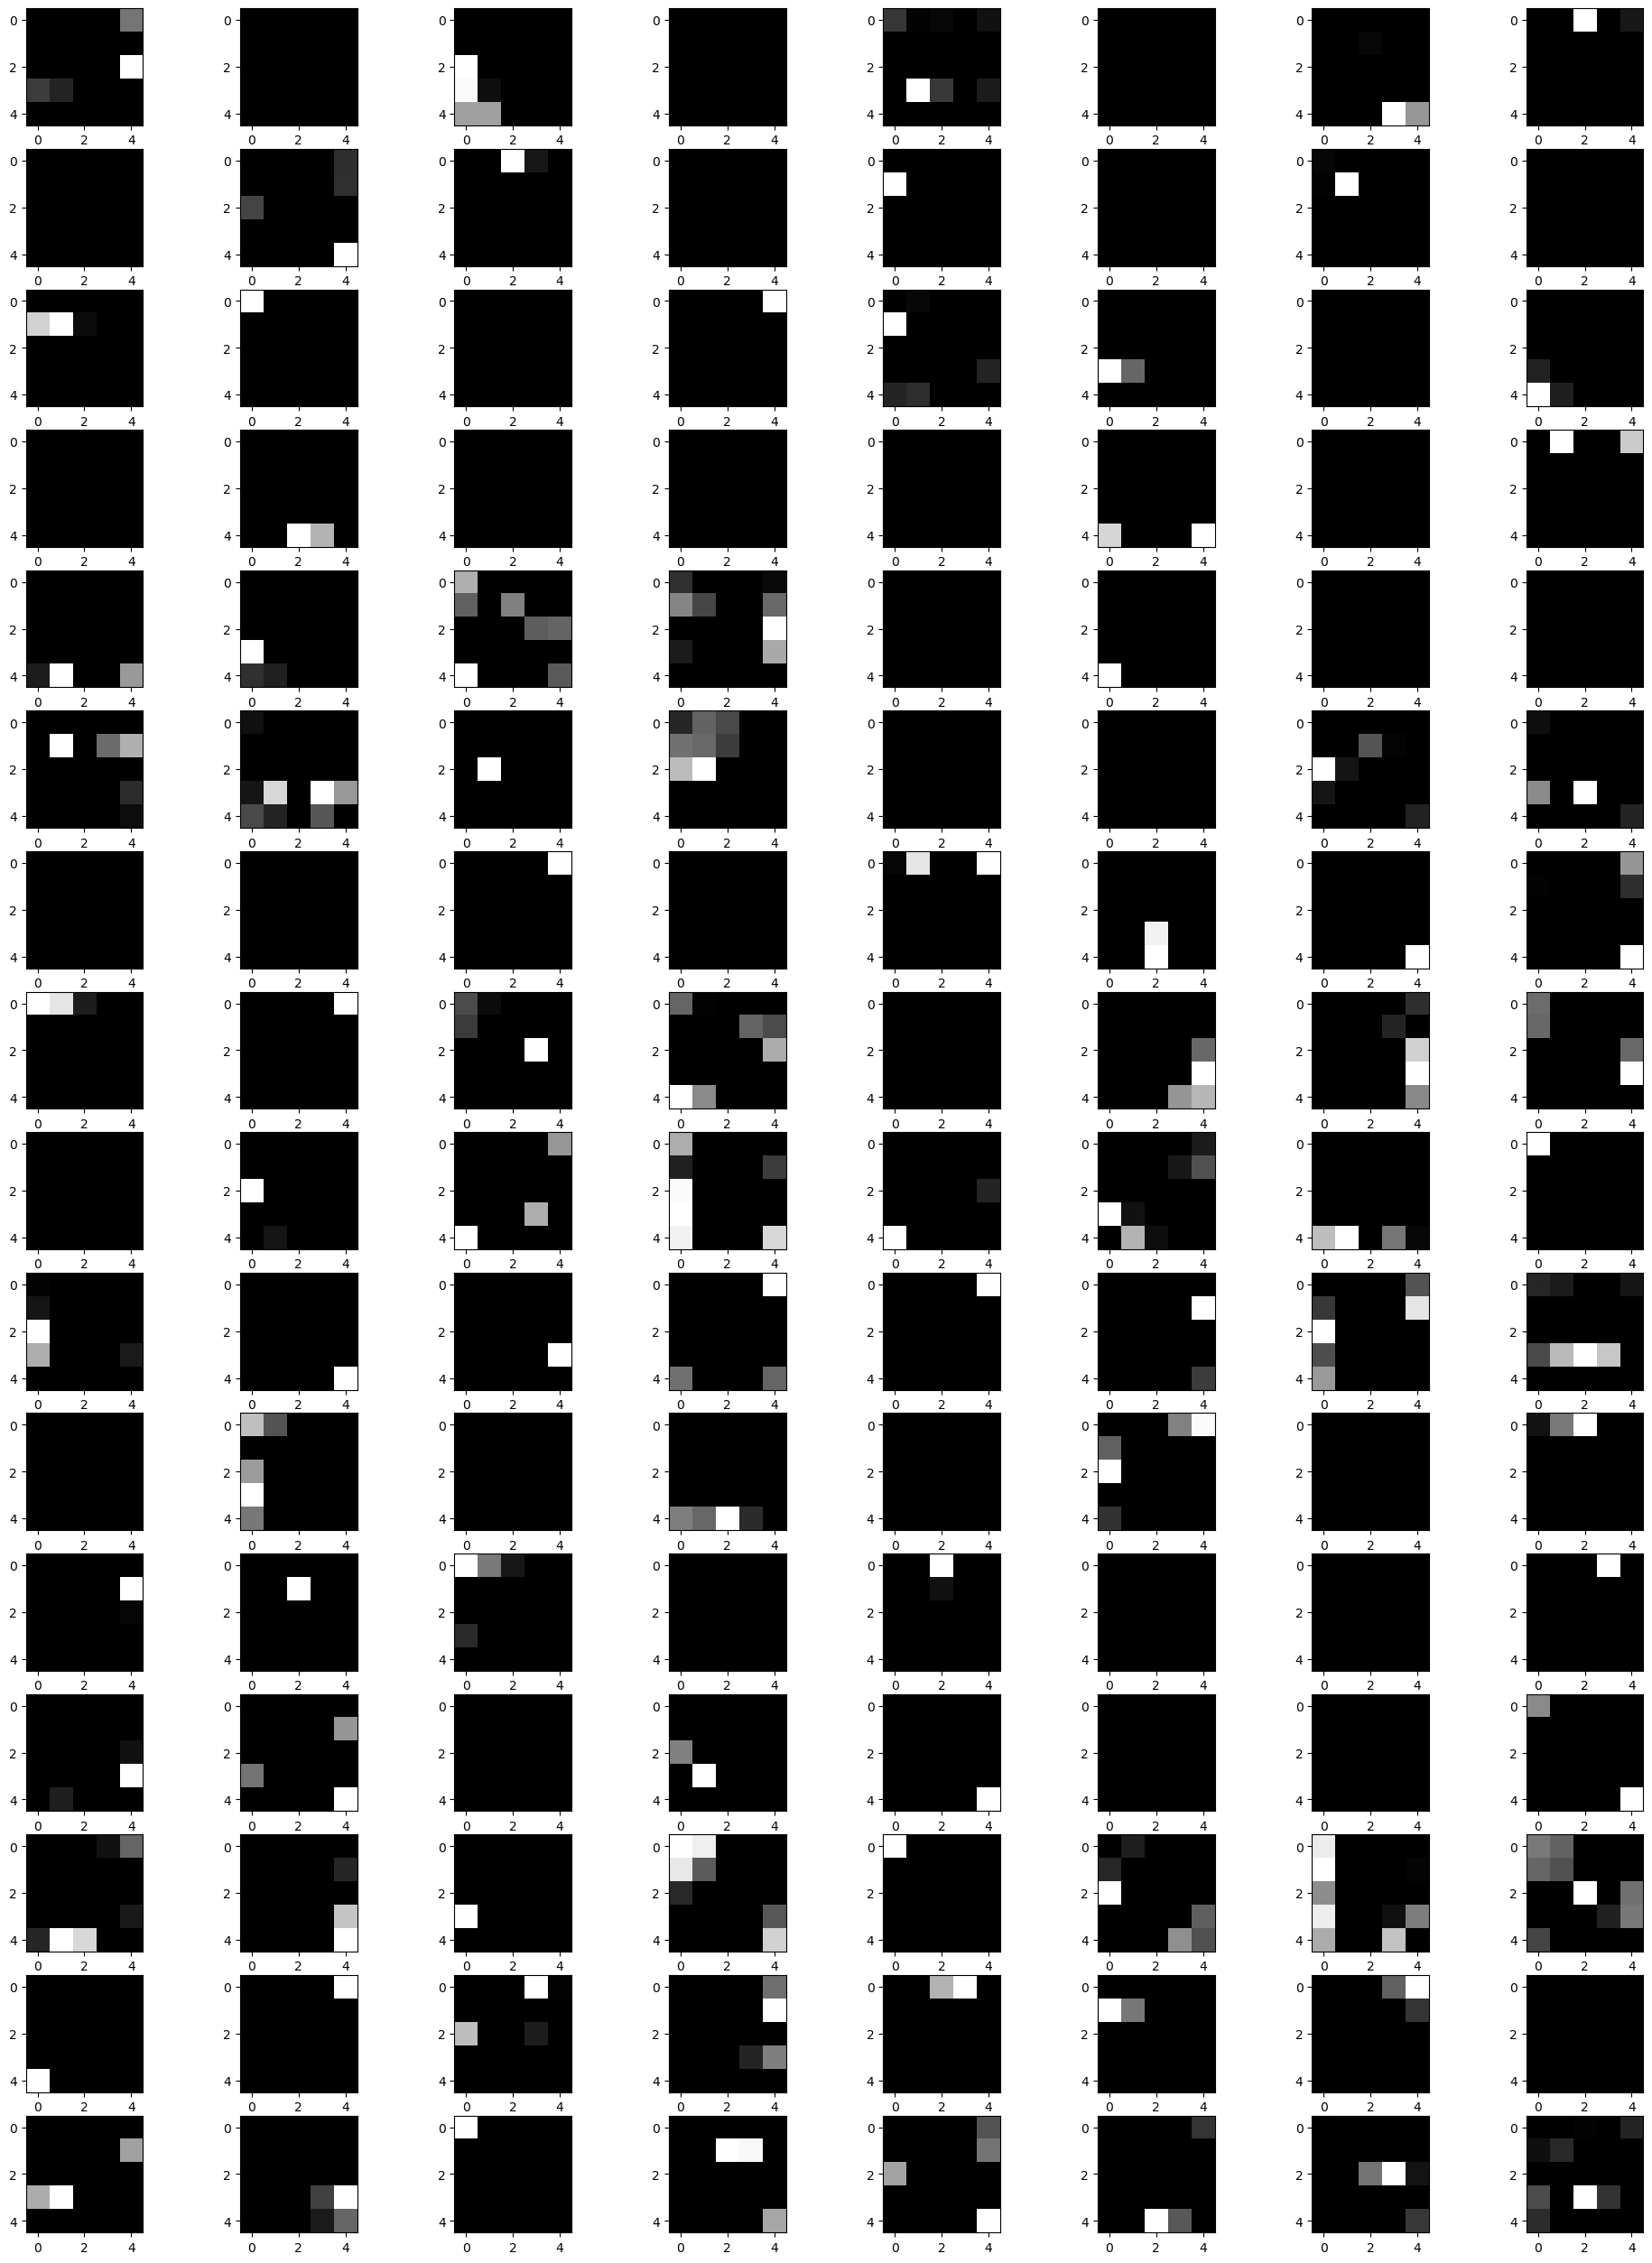

Show the reconstructed image patch for each filter of convolutional layer  2 which occured at layer  7 in the original model
Conv Layer 2  filter Size: 5  x  5  and border size (padding) of  2  and cumulative border from prior layers of  2


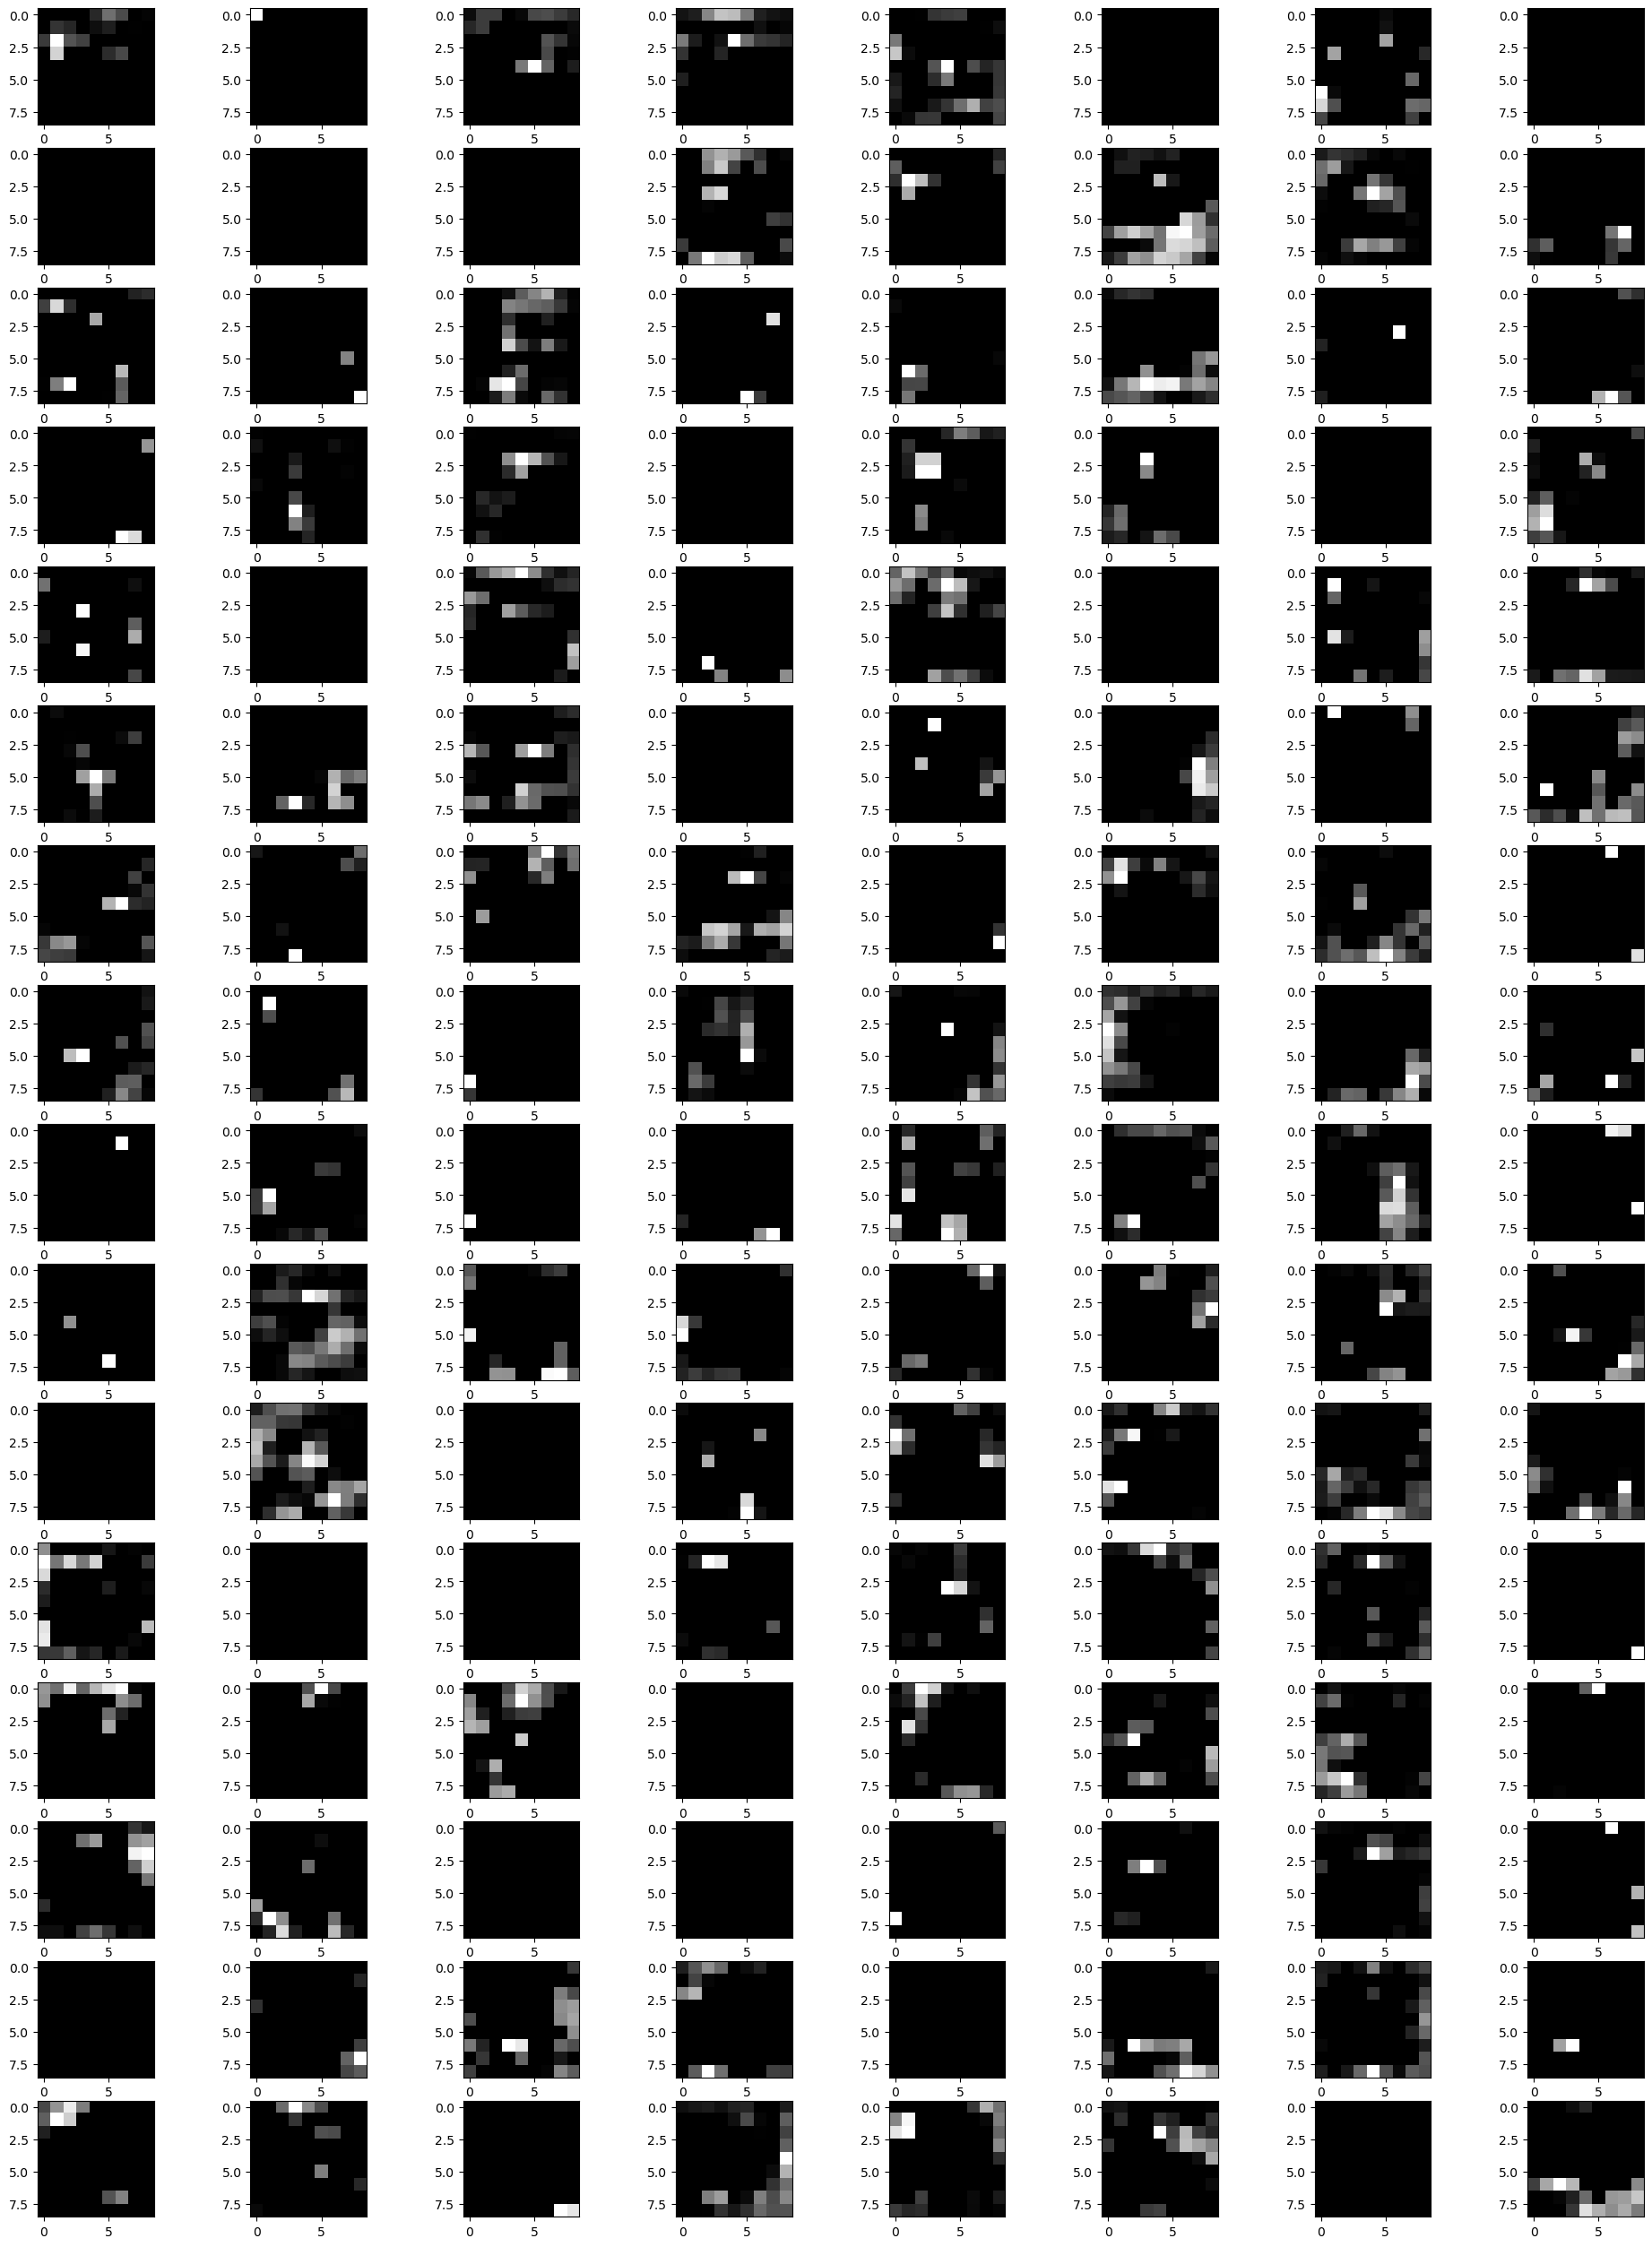

Show the reconstructed image patch for each filter of convolutional layer  3 which occured at layer  9 in the original model
Conv Layer 3  filter Size: 3  x  3  and border size (padding) of  1  and cumulative border from prior layers of  4


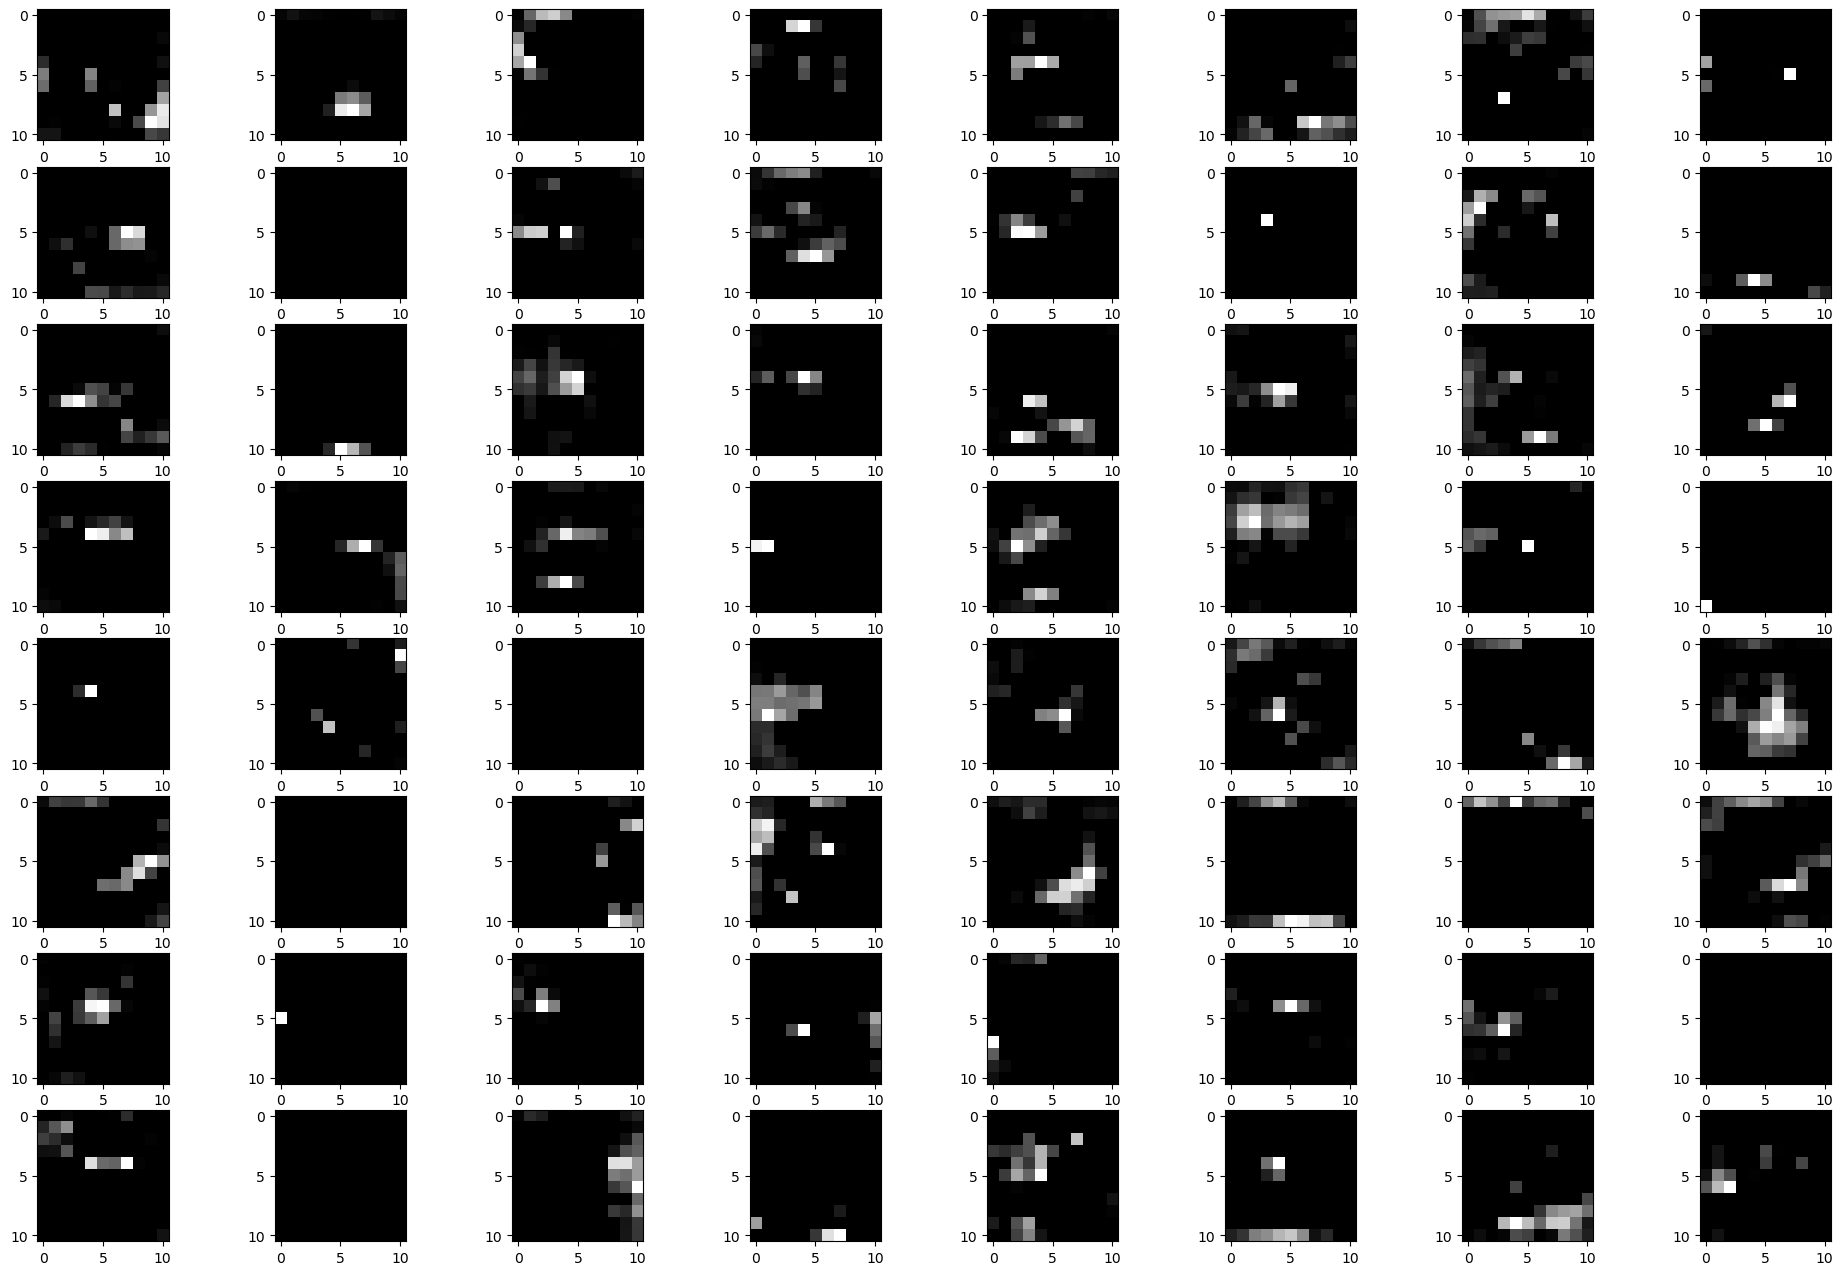

Show the reconstructed image patch for each filter of convolutional layer  4 which occured at layer  11 in the original model
Conv Layer 4  filter Size: 3  x  3  and border size (padding) of  1  and cumulative border from prior layers of  5


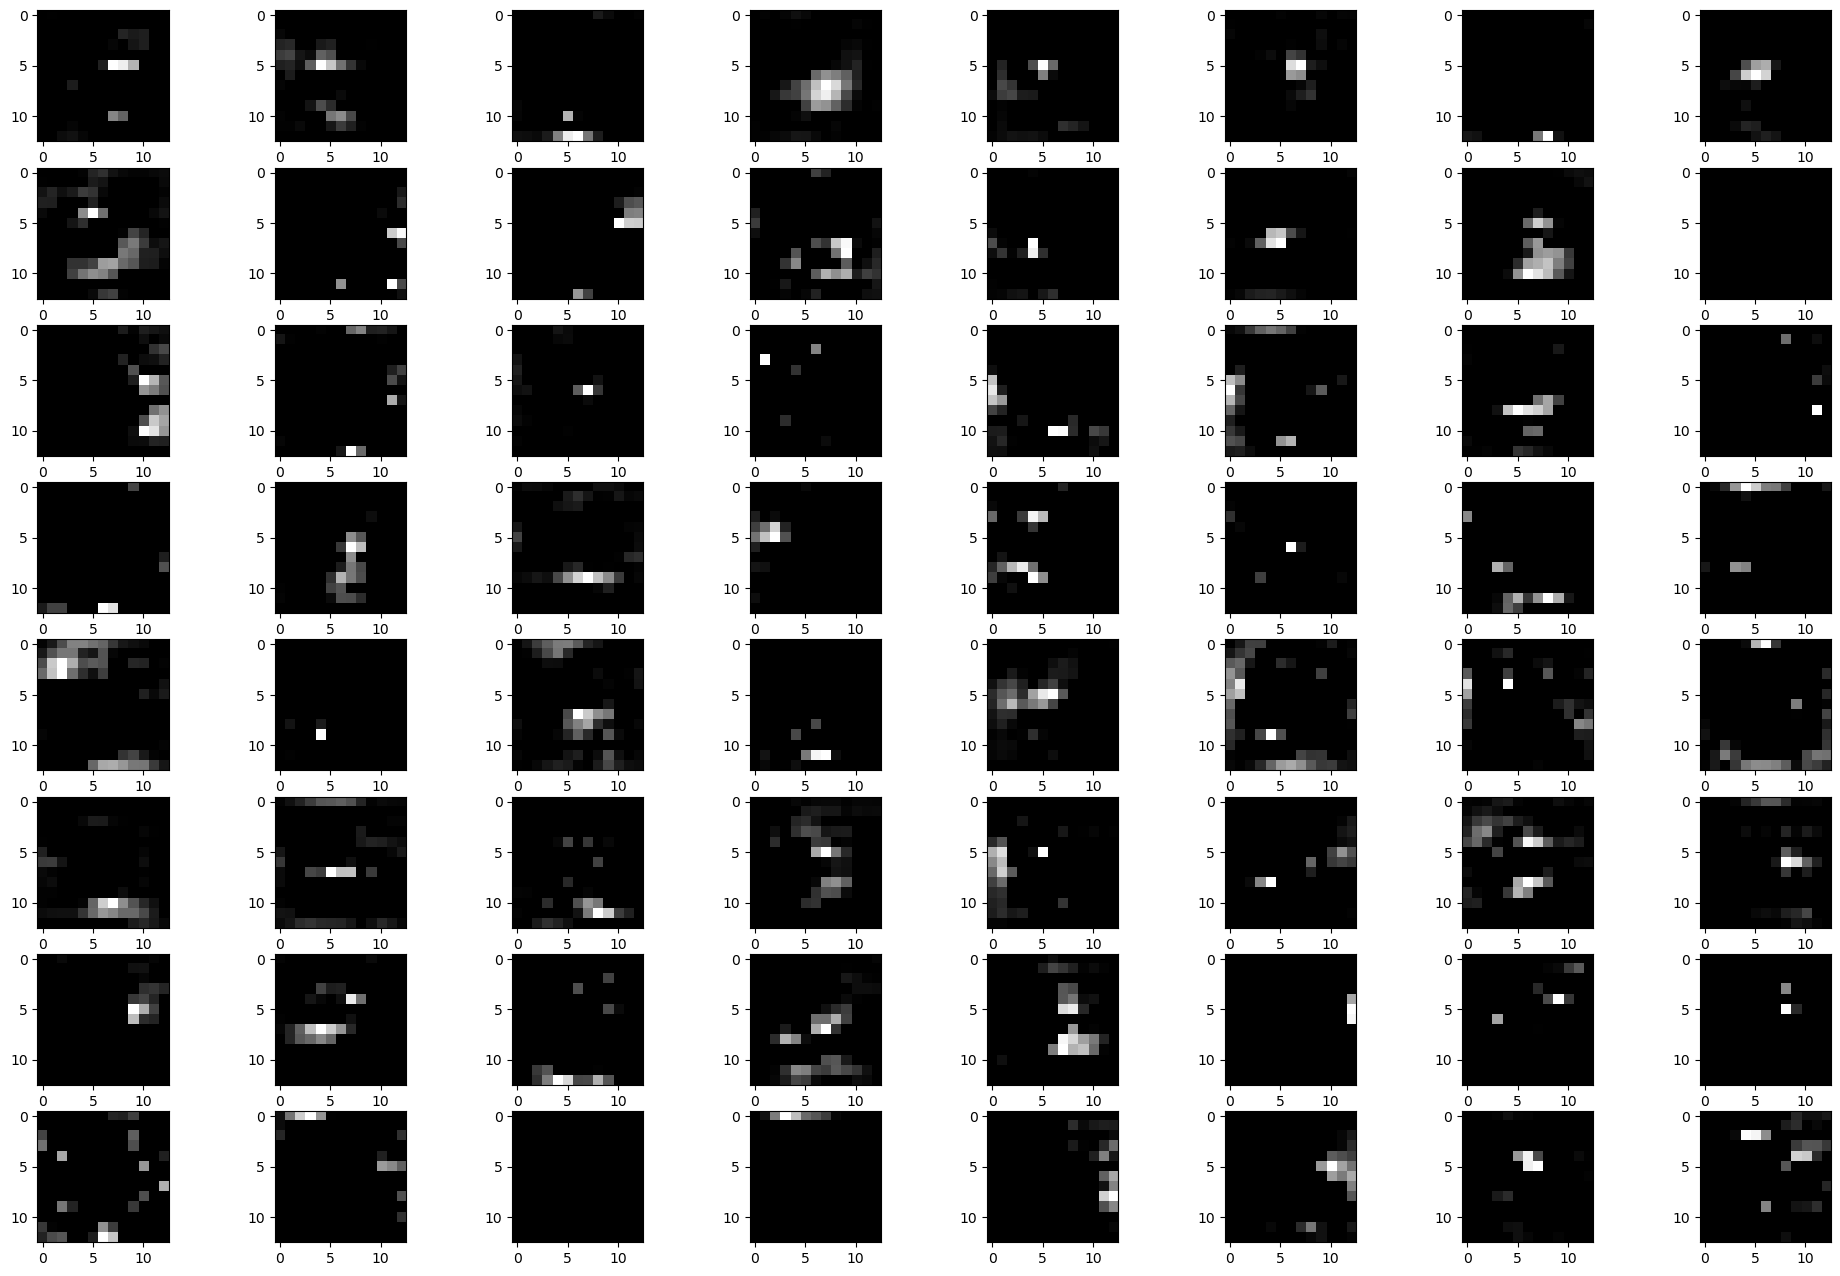

Show the reconstructed image patch for each filter of convolutional layer  5 which occured at layer  12 in the original model
Conv Layer 5  filter Size: 3  x  3  and border size (padding) of  1  and cumulative border from prior layers of  6


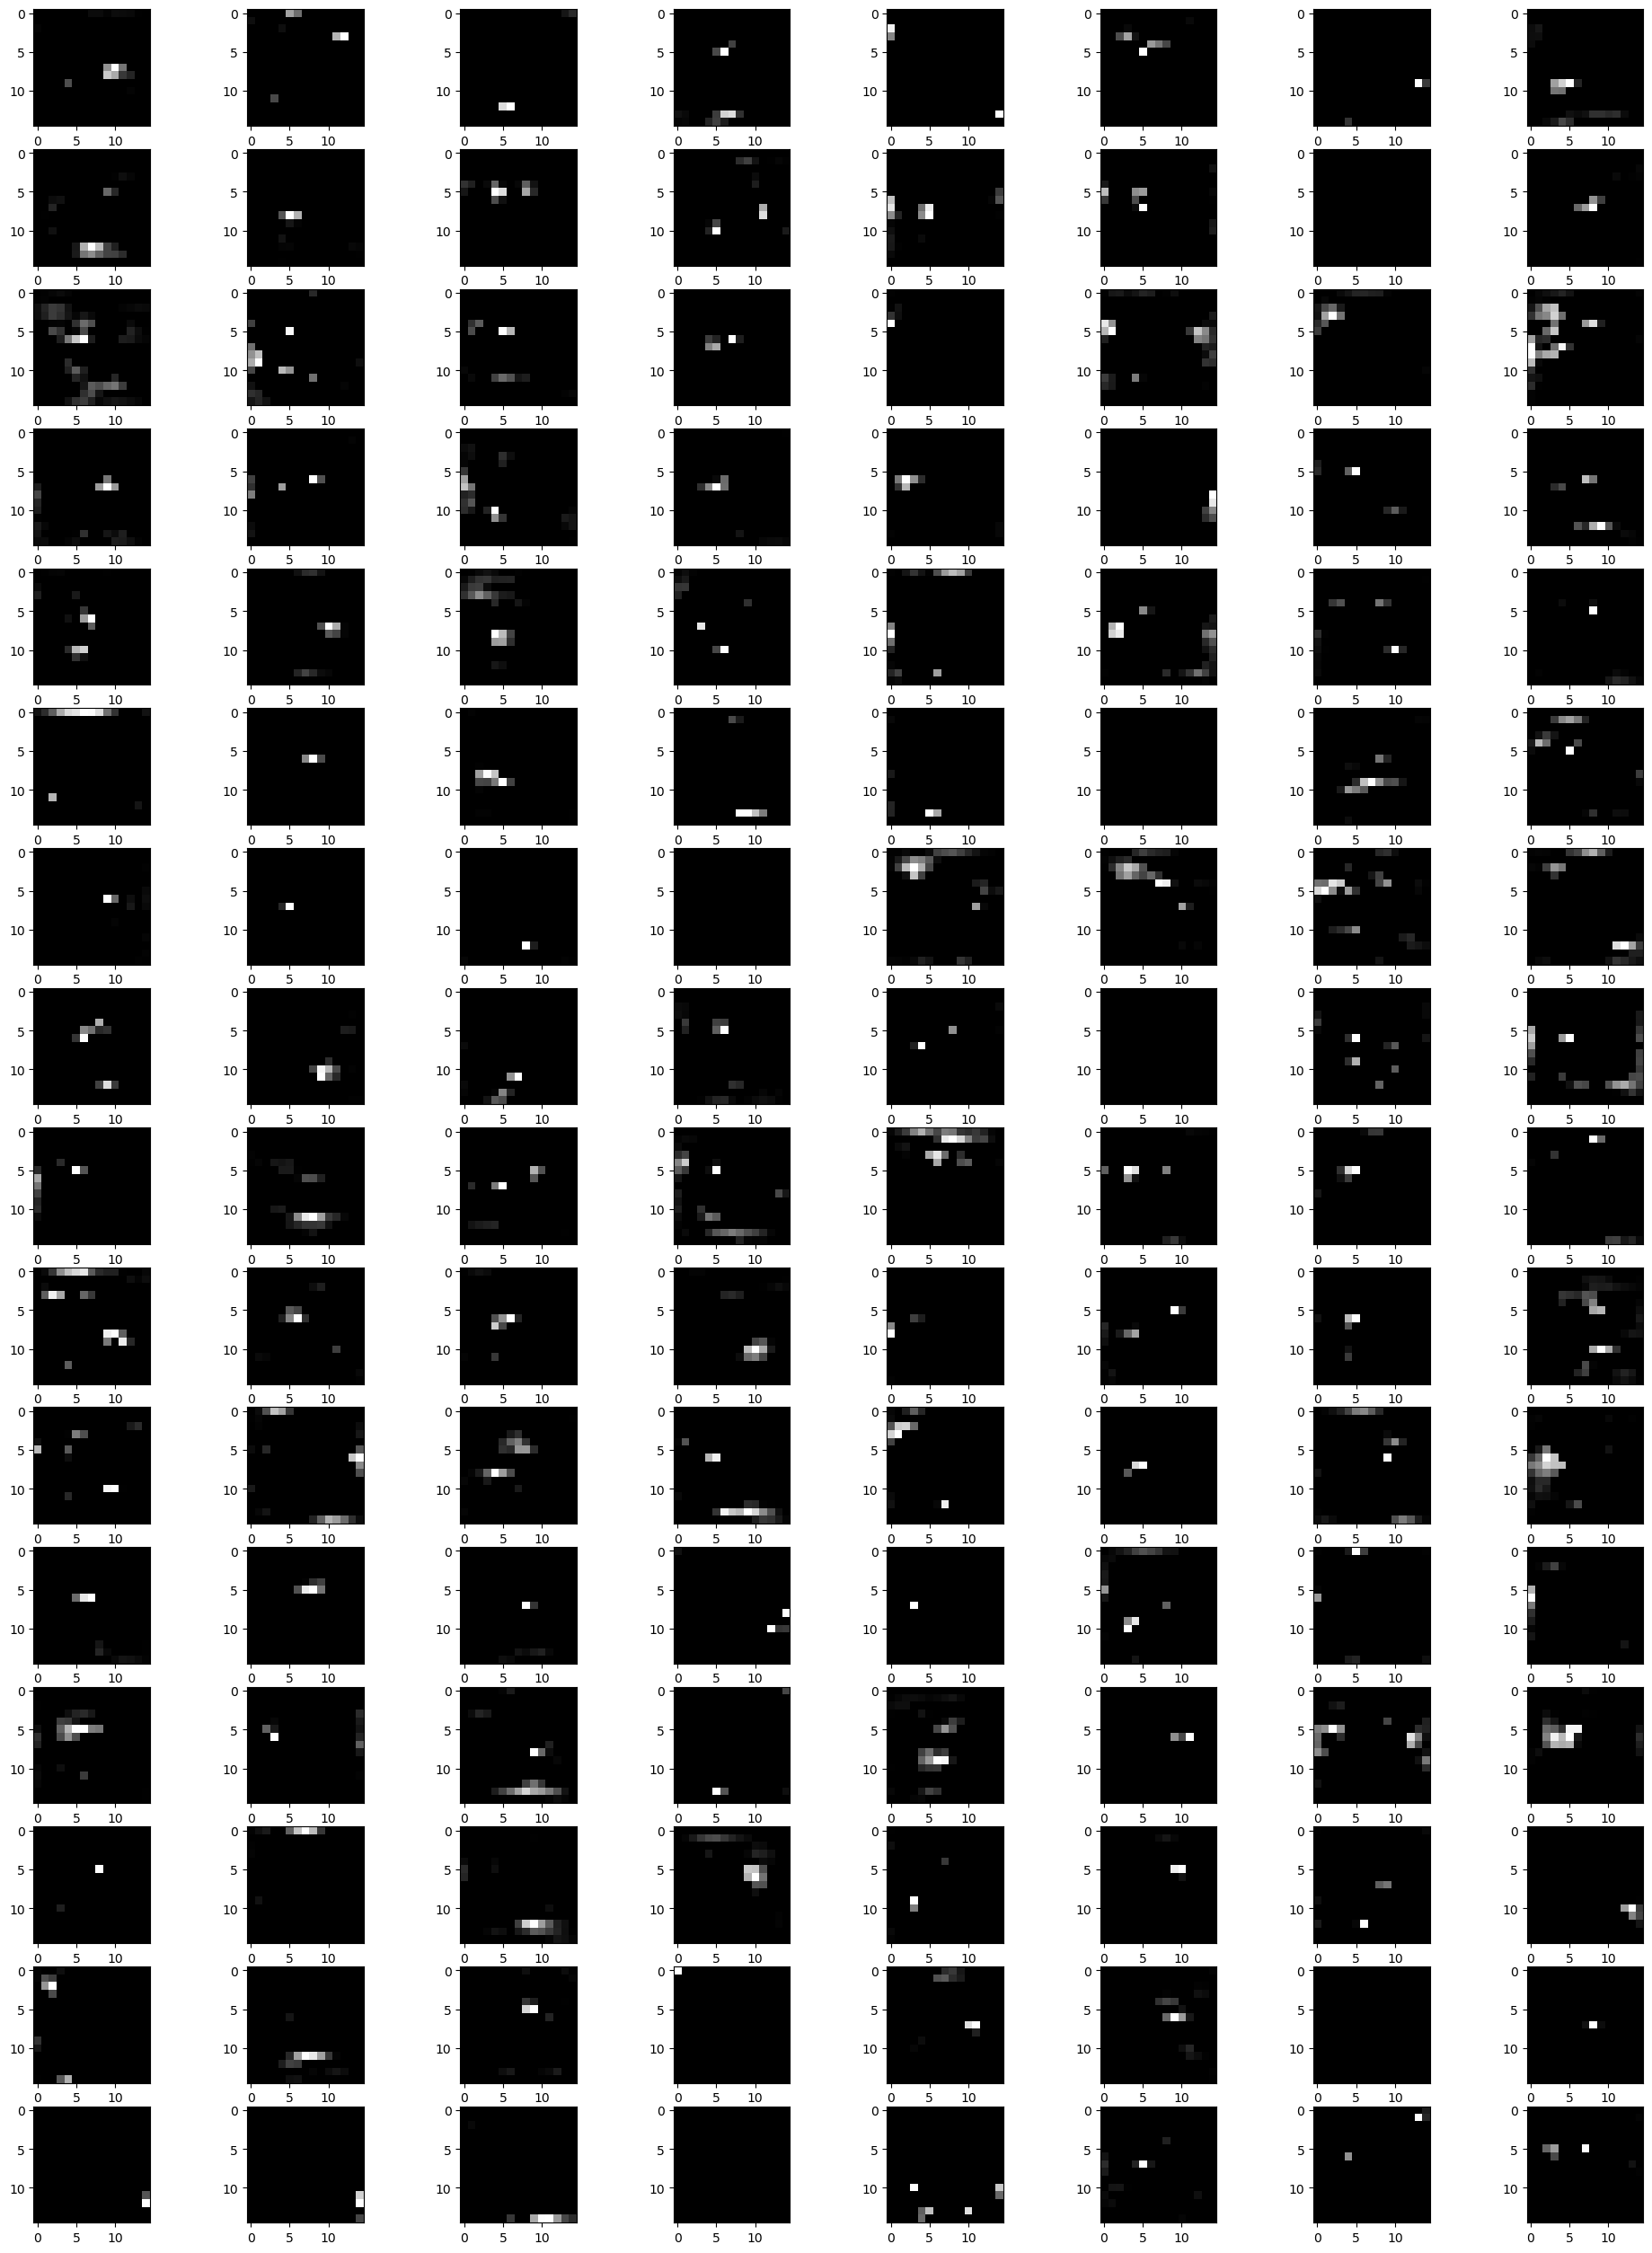

Show the reconstructed image patch for each filter of convolutional layer  6 which occured at layer  14 in the original model
Conv Layer 6  filter Size: 5  x  5  and border size (padding) of  2  and cumulative border from prior layers of  7


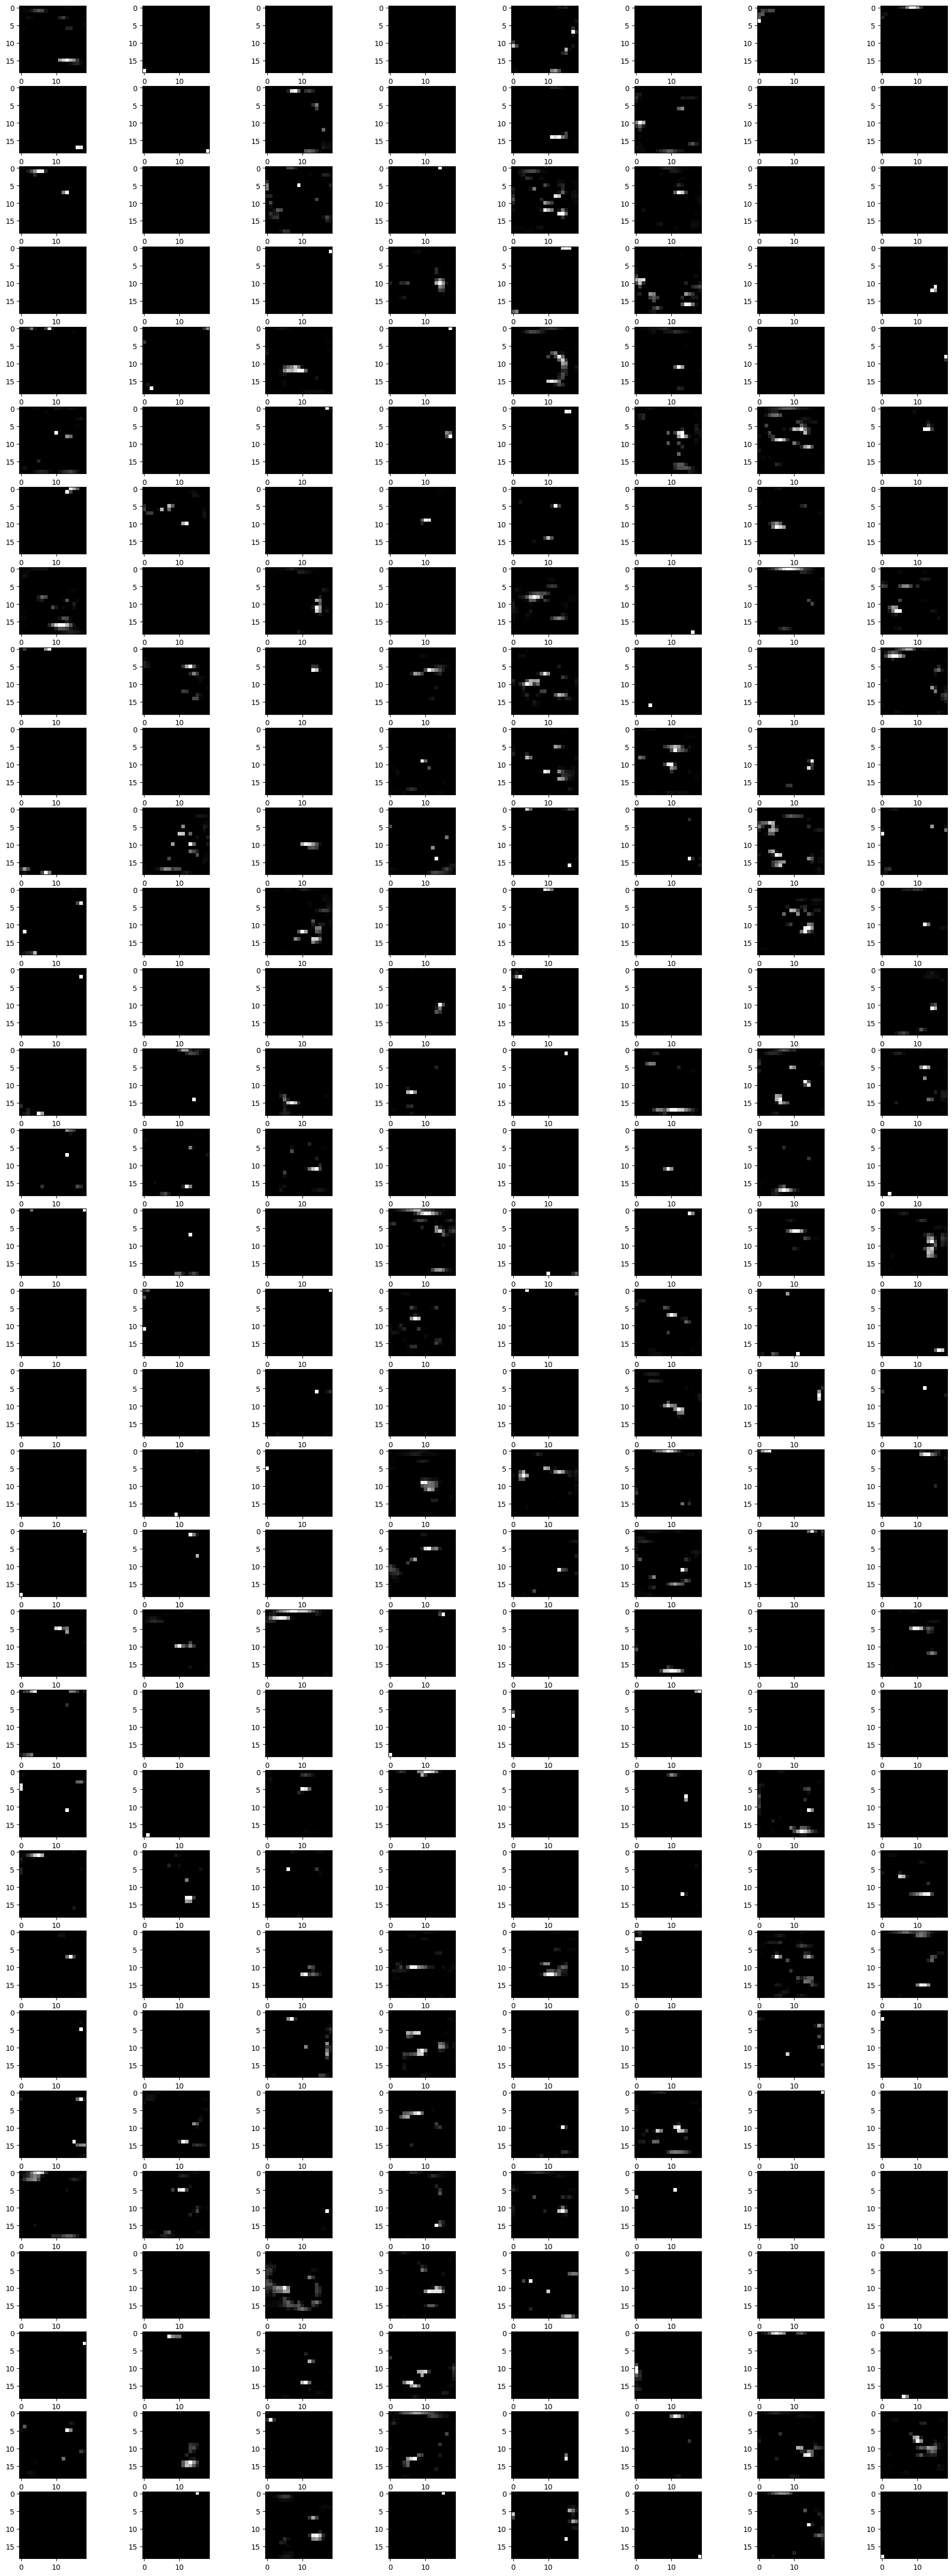

In [17]:
# a list of filter patches, one for each convolutional layer
num_filt = []            # number of filters in each Conv2D layer
filt_siz = []            # the size of each filter (assume they are square for now)
border_siz = []          # the size of the border around the center pixel of the square (assume filters are odd numbered dimensions like 3, 5, 7, etc.)
cumulative_border = []   # The cumulative effect of the borders from prior Conv3D layers
filter_patches = []      # The "mind reading" visualization of each filter - equal to the filter at the first Conv2D layer, but more complex later

for i in range (num_conv):
    conv_ind = conv_layer[i]
    print("Show the reconstructed image patch for each filter of convolutional layer ", i, "which occured at layer ",conv_ind, "in the original model")
    num_filt.append(Conv2D_weights[i].shape[3])
    # filter Size
    filt_siz.append(Conv2D_weights[i].shape[0])
    # Border size
    border_siz.append(int(filt_siz[i] / 2))
    cb = 0
    if i == 0 : 
        cumulative_border.append(0)
    else:
        for j in range(i) :
            cb += border_siz[j]
        cumulative_border.append(cb)
    print("Conv Layer", i, " filter Size:", filt_siz[i], " x ", filt_siz[i], 
          " and border size (padding) of ", border_siz[i], " and cumulative border from prior layers of ", cumulative_border[i])
    filter_patches.append(np.zeros((filt_siz[i] + 2 * cumulative_border[i], 
                                    filt_siz[i] + 2 * cumulative_border[i], 
                                    num_filt[i])))

    # For now, draw eight filters on a row for display purposes
    this_num_filt = num_filt[i]
    if (this_num_filt % 8 == 0) :
        drows = int(this_num_filt/8)
    else :
        drows = int(this_num_filt/8) + 1
    dcols = 8
    width = 24
    height = int(this_num_filt / 4)
    fig, ax = plt.subplots(nrows=drows, ncols=dcols, figsize=(width, height))
    
    thisrow = 0
    thiscol = 0
    # temporary variables for filter size and cumulative border size
    cb = cumulative_border[i]
    siz = filt_siz[i]
    image_patch = np.zeros((siz + 2 * cb, siz + 2 * cb))
    for this_filter in range(this_num_filt) :
        if i == 0 :
            image_patch = np.copy(Conv2D_weights[i][:, :, 0, this_filter])
        else:
            image_patch.fill(0)
            for x in range(cb, siz + cb, 1) :
                for y in range(cb, siz + cb, 1) :
                    for depth in range(num_filt[i-1]) :
                        image_patch[x-cb:x+cb+1, y-cb:y+cb+1] += np.copy((Conv2D_weights[i][x-cb, y-cb, depth, this_filter] * 
                                                                         filter_patches[i-1][:,:,depth]))
    
        filter_patches[i][:, :, this_filter] = np.copy(np.clip(image_patch, 0, 1e999)) # remove negative numbers (due to "relu" activation we used)
        
        # display the filter 
        if (drows > 1) :
            ax[thisrow, thiscol].imshow(filter_patches[i][:, :, this_filter], cmap="gray")
        else :
            ax[thiscol].imshow(filter_patches[i][:, :, this_filter], cmap="gray")
        thiscol += 1
        if (thiscol >=8) :
            thisrow += 1
            thiscol = 0
    
    plt.show()

## The above shows the filters of each Conv2D layer, multiplied by prior filters, to create a cumulative pattern being targeted by each successive layer (top to bottom)

## What can we learn from the above?
* We can see that successive convolution layers manage succesive levels of complexity. These are often described as edge detection first, then these are combined to form textures. Finally, the last convolution layer combines these textures to form patterns it is looking for in order to correctly identify birds. 
* Do we have too many convolutional layers in the middle? Examining the filters, are all the middle layers "adding value?"
* Looking at the last layer (the last group of images) we can see patterns the CNN is looking for. Specifically, look for the white areas and dark areas, and see if the white area is sloped upwards (the bird is going from a high frequency to a low frequency) or downwards (bird goes from low frequency to high frequency, otherwise known as a "chirp").
* Notice also that the specific frequency (musical notes) that the bird is singing is NOT shown at the convolution layer, just the pattern, which might be found at low frequencies or high ones. We would need to reconstruct the signal from the convolutional layer (work backwards through the network) to be able to discern what frequency / time does the pattern occur.


# What Does Bird "X" Sound Like?
## What if we don't have an input signal, and just work backwards from a classification (forced output)?
* We will repeat this for the first few birds, to see what the "Robot Mind" thinks that particular bird sounds like


## Starting with bird class 0 - "abethr1"
* We'll hear what an example original audio sounds like, and see the input features associated with it
* After that, we'll work backwards through the NN to approximate an input feature set (image) and from that audio best approximation
* Finally, we'll listen to what the NN has learned each bird "sounds like" - you may be surprised!

### Listen to an example of what that bird sounds like

Here is an example of original audio of this  African Bare-eyed Thrush  bird sounds like

This is the audio playback of the ORIGINAL audio file


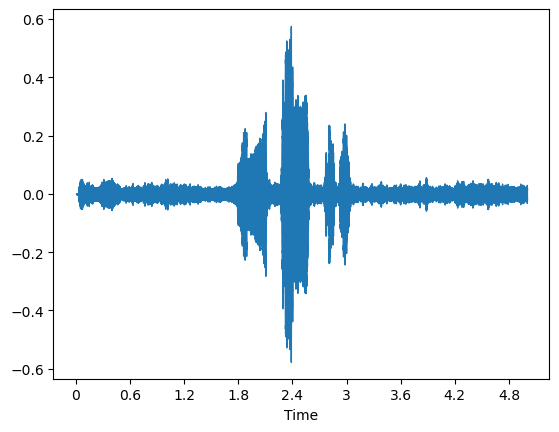

In [18]:
bird_class = 0
example_audio_index = 0
audio_filename = image_data.at[0,"filename"]
# Image files are now in the "input/v16e-gpu-all-birdclef2023-mindreader" directory instead of "working"
audio_filename = audio_filename.replace("working", "input/v16e-gpu-all-birdclef2023-mindreader")
common_name = image_data.at[0,"common_name"]
# load the audio data
audio, sr = librosa.load("/kaggle/input/birdclef-2023/train_audio/" + audio_filename, sr = sr)
# Take first 5 second "segment"
audio = audio[0:segment]

print("Here is an example of original audio of this ", common_name, " bird sounds like\n")
librosa.display.waveshow(audio, sr=sr)

print("This is the audio playback of the ORIGINAL audio file")
IPython.display.Audio(data = audio, rate=sr)

### For the above example, show the extracted features

These are teh features that will be used as input for the above example audio.



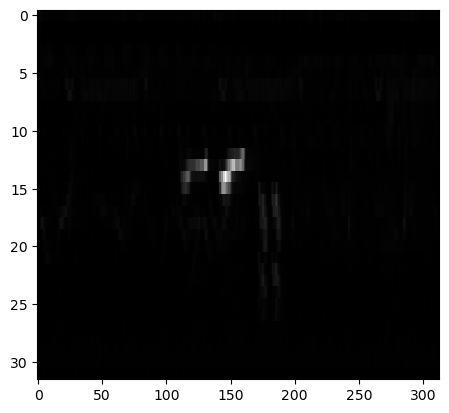

In [19]:
# These are the features for the above audio sample
feat = Audio_to_Domain(audio, sr)
# Move the range from current min and max, into 0 to 255 8 bit integers
fmin = feat.min()
fmax = feat.max()
frange = fmax - fmin
feat = np.array((((feat - fmin) / frange)*255), dtype='uint8')
print("These are teh features that will be used as input for the above example audio.\n")
plt.imshow(feat, cmap='gray', aspect=int(num_columns/num_rows) , interpolation = 'None')
plt.show() 

### Force the output category of the NN to be the above bird

Here is the forced output of our classification layer (the last Dense layer with Softmax activation)


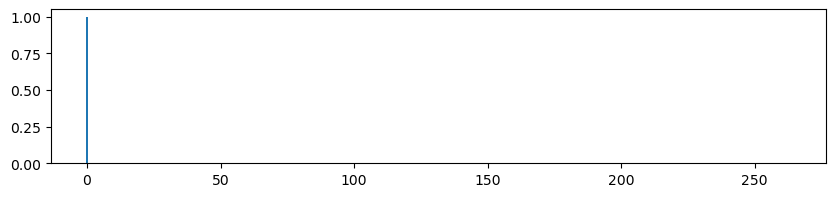

In [20]:
# Let's see if we can work backwards from a classification - in this case, we'll use the frst bird
bird_class = 0 # You can pick a different bird here if you wish
force_class = np.zeros(num_birds)
force_class[bird_class] = 1

print("Here is the forced output of our classification layer (the last Dense layer with Softmax activation)")
# Creating bar chart of Embed layer output values
x = np.arange(num_birds)

fig, ax = plt.subplots(figsize =(10, 2))
ax.bar(x, force_class)

# Show plot
plt.show()

Weights array from the embed layer to the class layer has the shape  (128, 264)
Here is the forced output of our embed layer (the first Dense layer after flattened last Conv layer)


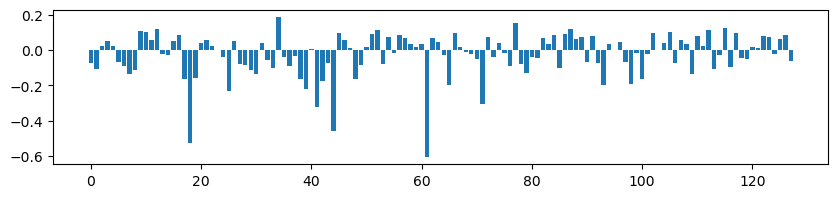

Weights array from the flattened last Conv layer to the embed has the shape  (159744, 128)


In [21]:
# Let's calculate the Embed layer for this forced classification
# Weights from the embed layer to the Classification layer
class_weights = np.copy(model_class.get_layer(index=class_layer).get_weights()[0])
print("Weights array from the embed layer to the class layer has the shape ", class_weights.shape)

num_embed_neurons = class_weights.shape[0]
num_class_neurons = class_weights.shape[1]
embed_data = np.zeros(num_embed_neurons)
for i in range(num_embed_neurons):
    for j in range(num_class_neurons):
        embed_data[i] += force_class[j] * class_weights[i, j]

print("Here is the forced output of our embed layer (the first Dense layer after flattened last Conv layer)")

# Creating bar chart of Embed layer output values
x = np.arange(num_embed_neurons)

fig, ax = plt.subplots(figsize =(10, 2))
ax.bar(x, embed_data)

# Show plot
plt.show()

# Weights from the embed layer to the Flatten-ed last Conv layer
embed_weights = np.copy(model_embed.get_layer(index=embed_layer).get_weights()[0])
print("Weights array from the flattened last Conv layer to the embed has the shape ", embed_weights.shape)

### Work backwards through the NN to recreate a best approximation of the input features, and audio, of the above bird.
* Essentially "What has the NN learned to be the audio feature set for the above bird, and what does it sound like?"

Weights array from the embed layer to the class layer has the shape  (159744, 128)
Weights array shape from the embed layer after undoing the Flatten  (8, 78, 256, 128)
Here is the best approximation of the input for this bird



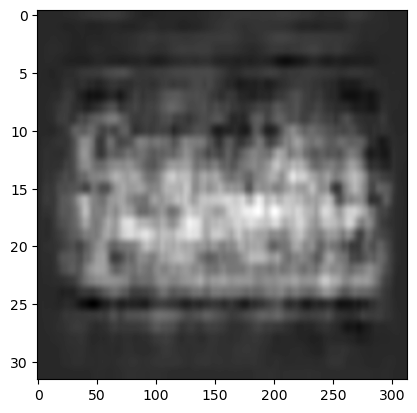

In [22]:
# Let's calculate the last Conv2D layer for this forced classification
# Weights from the last Conv2D layer to the embed layer
last_conv_weights_flat = np.copy(model.get_layer(index=embed_layer).get_weights()[0])
print("Weights array from the embed layer to the class layer has the shape ", last_conv_weights_flat.shape)

last_conv_weights = np.copy(np.reshape(last_conv_weights_flat, pre_flatten))
print("Weights array shape from the embed layer after undoing the Flatten ", last_conv_weights.shape)

# The last convolutional network  is a 3 dimensional arrax of dimensions rows x columns x filters
num_conv_rows = last_conv_weights.shape[0]
num_conv_cols = last_conv_weights.shape[1]
num_conv_filt = last_conv_weights.shape[2]
# In addition, each of these rows x columns x filter outputs is connected to a dense layer with a number of neurons (called the embed layer)
num_embed_neurons = last_conv_weights.shape[3]

# As we build visualizations of each Convolutioal Layer, we cumulatively created "filter patches" that 
# represent all of the prior Convolutional layers as well. Because of this, we don't need to 
# recalculate each layer backwards. We can just use the forward calculated final convolutional layer
# filter patch
last_conv_layer = num_conv - 1
last_filter_patches = filter_patches[last_conv_layer]

# We will use the values of the embed layer (called embed_data here) multiplied by all
# the corresponding weights that connected the last convolutional layer to that embed
# layer (we took care of the "Flatten" above), and those values are the multiplier
# we will apply to each filter patch at the respective location of the recreation.
# In this way, we are moving backwards through the NN; from embed, to last Convolutional
# layer, and finally all the way to a best approximation of the input.
# NOTE: Since we used padding in the forward pass, we'll need to add a border to 
# our workspace input recreation
border = int(last_filter_patches.shape[0]/2) 
extra_pixels = 2 * border 

# Create the workspace where individual filter patchess will be weighted and added up
conv_data1 = np.zeros((num_conv_rows + extra_pixels, num_conv_cols + extra_pixels))
# add 'em up
for i in range(num_embed_neurons):
    embed_value = embed_data[i] # using local variables to speed things up
    for j in range(num_conv_filt):
        this_filter_patch = last_filter_patches[:,:,j]
        this_conv_to_embed_weights = last_conv_weights[:,:,j,i]
        for k in range(border, num_conv_cols + border, 1):
            for l in range(border, num_conv_rows + border, 1):
                conv_data1[l-border:l+border+1, k-border:k+border+1] += this_filter_patch[:,:] * this_conv_to_embed_weights[l-border,k-border] * embed_value
                

conv_data2 = np.copy(conv_data1)
PIL_image = Image.fromarray(conv_data2)
conv_data = np.array(PIL_image.resize([num_columns, num_rows]))

print("Here is the best approximation of the input for this bird\n")
plt.imshow(conv_data, cmap="gray", aspect=(num_columns/num_rows))


In [23]:
x = model.predict(np.reshape(conv_data, (1, num_rows, num_columns, 1)))

print("As noted above, recreation of input does not mean that recreation will be classified the same way. \n",
      "In fact, using the above as input, the NN categorizes this as bird number ", x.argmax())

1/1 [==============================] - 0s 484ms/step
As noted above, recreation of input does not mean that recreation will be classified the same way. 
 In fact, using the above as input, the NN categorizes this as bird number  245


After scaling, normalized transform has values within this range:  -0.53536165 2.7840617
This is the recreated audio, (un-transformed) hear and see as a graphic file


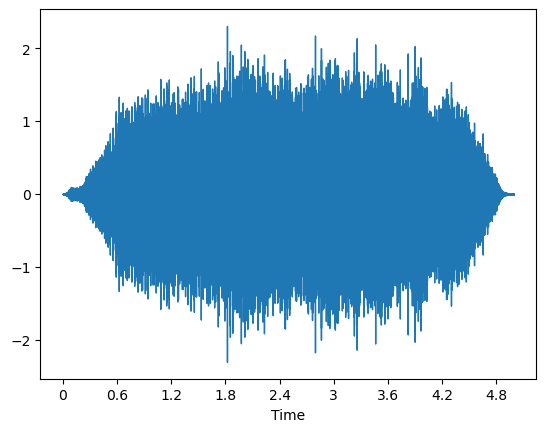

In [24]:
print("After scaling, normalized transform has values within this range: ", conv_data.min(), conv_data.max())
untrans_1 = Domain_to_Audio(conv_data, sr)
print("This is the recreated audio, (un-transformed) hear and see as a graphic file")
librosa.display.waveshow(untrans_1, sr=sr)
IPython.display.Audio(data = untrans_1, rate=sr)

## The above is what the AI "thinks bird class 0 - abethr1 - sounds like." 
If you'll forgive the personification, pretending like the AI is actually thinking
### What can we learn from the above?
* We can see that certain important frequencies appear in the same position (in the extracted feature image)
* We can see that certain important cadences (low to high notes, versus high to low notes) can be spotted
* Some information, such as rhythm/timing of repeated sounds, seems to be completely lost.
* We see that quite a bit of information has been thrown away (I can't tell what bird it is from the audio, and probabbly neither can an expert).
* Could this discarded information be important? Experts would say "yes" but AI researchers migth be OK with a good score only.

## Next is bird class 1 - "abhori1"
* We'll hear what an example original audio sounds like
* After that, we'll work backwards through the NN to approximate an input feature set (image) and from that audio best approximation
* Listen to what the NN has learned each bird "sounds like" - you may be surprised!

### Listen to an example of what that bird sounds like

Here is an example of original audio of this  African Black-headed Oriole  bird sounds like

This is the audio playback of the ORIGINAL audio file


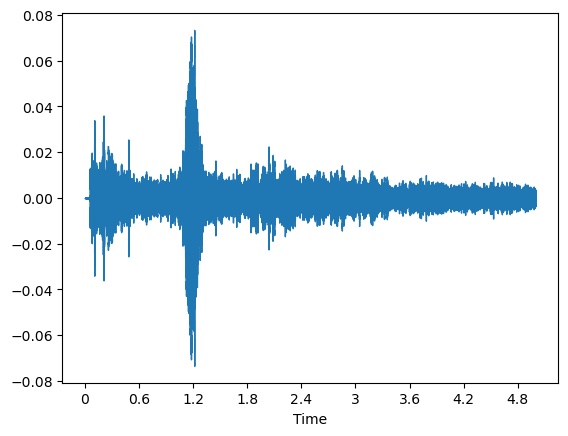

In [25]:
bird_class = 1
example_audio_index = 15
audio_filename = image_data.at[example_audio_index,"filename"]
# Image files are now in the "input/v16e-gpu-all-birdclef2023-mindreader" directory instead of "working"
audio_filename = audio_filename.replace("working", "input/v16e-gpu-all-birdclef2023-mindreader")
common_name = image_data.at[example_audio_index,"common_name"]
# load the audio data
audio, sr = librosa.load("/kaggle/input/birdclef-2023/train_audio/" + audio_filename, sr = sr)
# Take first 5 second "segment"
audio = audio[0:segment]

print("Here is an example of original audio of this ", common_name, " bird sounds like\n")
librosa.display.waveshow(audio, sr=sr)

print("This is the audio playback of the ORIGINAL audio file")
IPython.display.Audio(data = audio, rate=sr)

### For the above example, show the extracted features

These are the features that will be used as input for the above example audio.



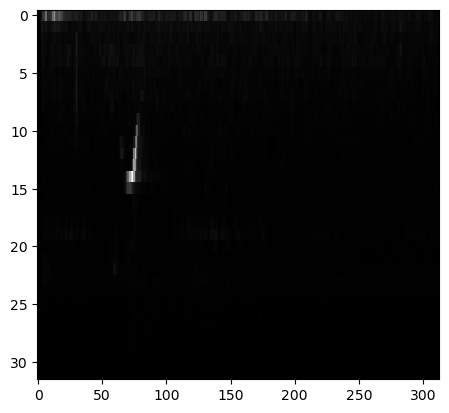

In [26]:
# These are the features for the above audio sample
feat = Audio_to_Domain(audio, sr)
# Move the range from current min and max, into 0 to 255 8 bit integers
fmin = feat.min()
fmax = feat.max()
frange = fmax - fmin
feat = np.array((((feat - fmin) / frange)*255), dtype='uint8')
print("These are the features that will be used as input for the above example audio.\n")
plt.imshow(feat, cmap='gray', aspect=int(num_columns/num_rows) , interpolation = 'None')
plt.show() 

### Force the output category of the NN to be the above bird

Here is the forced output of our classification layer (the last Dense layer with Softmax activation)


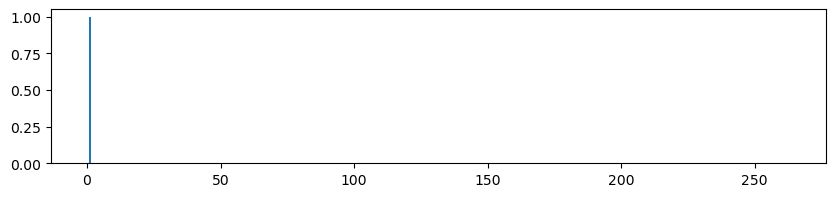

In [27]:
# Let's see if we can work backwards from a classification - in this case, we'll use the frst bird
bird_class = 1 # You can pick a different bird here if you wish
force_class = np.zeros(num_birds)
force_class[bird_class] = 1

print("Here is the forced output of our classification layer (the last Dense layer with Softmax activation)")
# Creating bar chart of Embed layer output values
x = np.arange(num_birds)

fig, ax = plt.subplots(figsize =(10, 2))
ax.bar(x, force_class)

# Show plot
plt.show()

Weights array from the embed layer to the class layer has the shape  (128, 264)
Here is the forced output of our embed layer (the first Dense layer after flattened last Conv layer)


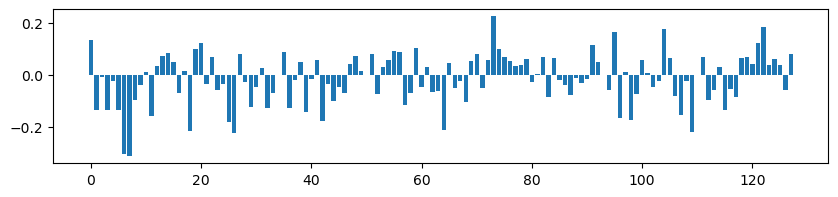

Weights array from the flattened last Conv layer to the embed has the shape  (159744, 128)


In [28]:
# Let's calculate the Embed layer for this forced classification
# Weights from the embed layer to the Classification layer
class_weights = np.copy(model_class.get_layer(index=class_layer).get_weights()[0])
print("Weights array from the embed layer to the class layer has the shape ", class_weights.shape)

num_embed_neurons = class_weights.shape[0]
num_class_neurons = class_weights.shape[1]
embed_data = np.zeros(num_embed_neurons)
for i in range(num_embed_neurons):
    for j in range(num_class_neurons):
        embed_data[i] += force_class[j] * class_weights[i, j]

print("Here is the forced output of our embed layer (the first Dense layer after flattened last Conv layer)")
# Creating bar chart of Embed layer output values
x = np.arange(num_embed_neurons)

fig, ax = plt.subplots(figsize =(10, 2))
ax.bar(x, embed_data)

# Show plot
plt.show()

# Weights from the embed layer to the Flatten-ed last Conv layer
embed_weights = np.copy(model_embed.get_layer(index=embed_layer).get_weights()[0])
print("Weights array from the flattened last Conv layer to the embed has the shape ", embed_weights.shape)

### Work backwards through the NN to recreate a best approximation of the input features, and audio, of the above bird.
* Essentially "What has the NN learned to be the audio feature set for the above bird, and what does it sound like?"

Weights array from the embed layer to the class layer has the shape  (159744, 128)
Weights array shape from the embed layer after undoing the Flatten  (8, 78, 256, 128)
Here is the best approximation of the input for this bird



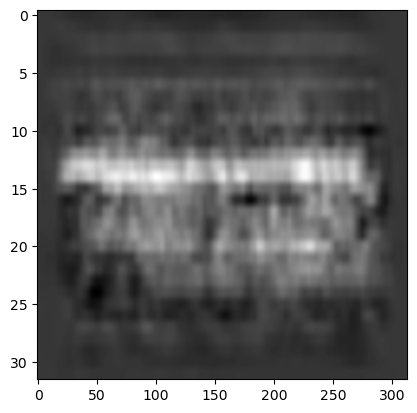

In [29]:
# Let's calculate the last Conv2D layer for this forced classification
# Weights from the last Conv2D layer to the embed layer
last_conv_weights_flat = np.copy(model.get_layer(index=embed_layer).get_weights()[0])
print("Weights array from the embed layer to the class layer has the shape ", last_conv_weights_flat.shape)

last_conv_weights = np.copy(np.reshape(last_conv_weights_flat, pre_flatten))
print("Weights array shape from the embed layer after undoing the Flatten ", last_conv_weights.shape)

# The last convolutional network  is a 3 dimensional arrax of dimensions rows x columns x filters
num_conv_rows = last_conv_weights.shape[0]
num_conv_cols = last_conv_weights.shape[1]
num_conv_filt = last_conv_weights.shape[2]
# In addition, each of these rows x columns x filter outputs is connected to a dense layer with a number of neurons (called the embed layer)
num_embed_neurons = last_conv_weights.shape[3]

# As we build visualizations of each Convolutioal Layer, we cumulatively created "filter patches" that 
# represent all of the prior Convolutional layers as well. Because of this, we don't need to 
# recalculate each layer backwards. We can just use the forward calculated final convolutional layer
# filter patch
last_conv_layer = num_conv - 1
last_filter_patches = filter_patches[last_conv_layer]

# We will use the values of the embed layer (called embed_data here) multiplied by all
# the corresponding weights that connected the last convolutional layer to that embed
# layer (we took care of the "Flatten" above), and those values are the multiplier
# we will apply to each filter patch at the respective location of the recreation.
# In this way, we are moving backwards through the NN; from embed, to last Convolutional
# layer, and finally all the way to a best approximation of the input.
# NOTE: Since we used padding in the forward pass, we'll need to add a border to 
# our workspace input recreation
border = int(last_filter_patches.shape[0]/2) 
extra_pixels = 2 * border 

# Create the workspace where individual filter patchess will be weighted and added up
conv_data1 = np.zeros((num_conv_rows + extra_pixels, num_conv_cols + extra_pixels))
# add 'em up
for i in range(num_embed_neurons):
    embed_value = embed_data[i] # using local variables to speed things up
    for j in range(num_conv_filt):
        this_filter_patch = last_filter_patches[:,:,j]
        this_conv_to_embed_weights = last_conv_weights[:,:,j,i]
        for k in range(border, num_conv_cols + border, 1):
            for l in range(border, num_conv_rows + border, 1):
                conv_data1[l-border:l+border+1, k-border:k+border+1] += this_filter_patch[:,:] * this_conv_to_embed_weights[l-border,k-border] * embed_value
                
conv_data2 = np.copy(conv_data1) # [border:num_conv_rows + border, border:num_conv_cols + border])
PIL_image = Image.fromarray(conv_data2)
conv_data = np.array(PIL_image.resize([num_columns, num_rows]))

print("Here is the best approximation of the input for this bird\n")
plt.imshow(conv_data, cmap="gray", aspect=(num_columns/num_rows))


In [30]:
x = model.predict(np.reshape(conv_data, (1, num_rows, num_columns, 1)))

print("As noted above, recreation of input does not mean that recreation will be classified the same way. \n",
      "Using the above as input, the NN categorizes this as bird number ", x.argmax())

1/1 [==============================] - 0s 91ms/step
As noted above, recreation of input does not mean that recreation will be classified the same way. 
 Using the above as input, the NN categorizes this as bird number  20


After scaling, normalized transform has values within this range:  -0.64578676 2.332351
This is the recreated audio, (un-transformed) hear and see as a graphic file


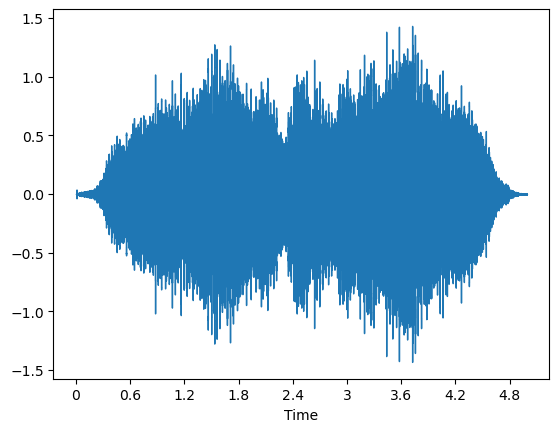

In [31]:
print("After scaling, normalized transform has values within this range: ", conv_data.min(), conv_data.max())
untrans_1 = Domain_to_Audio(conv_data, sr)
print("This is the recreated audio, (un-transformed) hear and see as a graphic file")
librosa.display.waveshow(untrans_1, sr=sr)
IPython.display.Audio(data = untrans_1, rate=sr)

## The above is what the AI "thinks bird class 1 - abhori1 - sounds like."
* Many of the same observations regarding retained vversus discarded information

## Finally bird class 2 - "abythr1"
* We'll hear what an example original audio sounds like
* After that, we'll work backwards through the NN to approximate an input feature set (image) and from that audio best approximation
* Listen to what the NN has learned each bird "sounds like" - you may be surprised!

### Listen to an example of what that bird sounds like

Here is an example of original audio of this  Abyssinian Thrush  bird sounds like

This is the audio playback of the ORIGINAL audio file


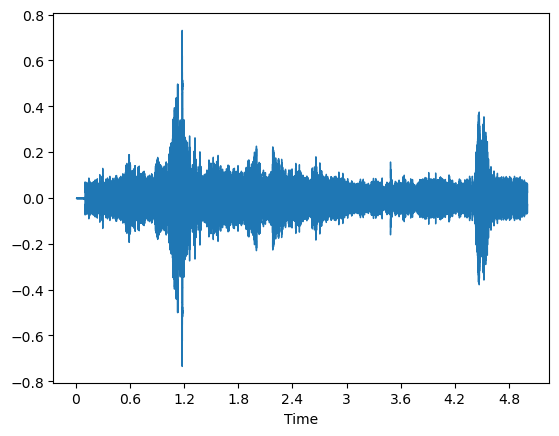

In [32]:
bird_class = 2
example_audio_index = 141
audio_filename = image_data.at[example_audio_index,"filename"]
# Image files are now in the "input/v16e-gpu-all-birdclef2023-mindreader" directory instead of "working"
audio_filename = audio_filename.replace("working", "inputv16e-gpu-all-birdclef2023-mindreader")
common_name = image_data.at[example_audio_index,"common_name"]
# load the audio data
audio, sr = librosa.load("/kaggle/input/birdclef-2023/train_audio/" + audio_filename, sr = sr)
# Take first 5 second "segment"
audio = audio[0:segment]

print("Here is an example of original audio of this ", common_name, " bird sounds like\n")
librosa.display.waveshow(audio, sr=sr)

print("This is the audio playback of the ORIGINAL audio file")
IPython.display.Audio(data = audio, rate=sr)

### For the above example, show the extracted features

These are teh features that will be used as input for the above example audio.



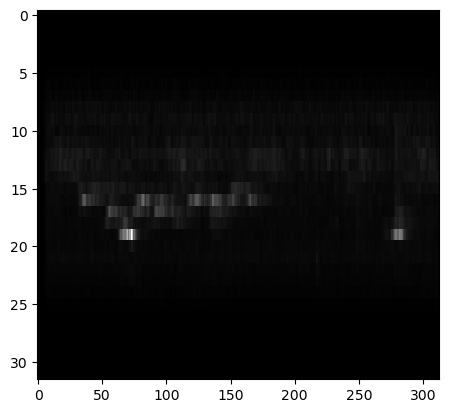

In [33]:
# These are the features for the above audio sample
feat = Audio_to_Domain(audio, sr)
# Move the range from current min and max, into 0 to 255 8 bit integers
fmin = feat.min()
fmax = feat.max()
frange = fmax - fmin
feat = np.array((((feat - fmin) / frange)*255), dtype='uint8')
print("These are teh features that will be used as input for the above example audio.\n")
plt.imshow(feat, cmap='gray', aspect=int(num_columns/num_rows) , interpolation = 'None')
plt.show() 

### Force the output category of the NN to be the above bird

Here is the forced output of our classification layer (the last Dense layer with Softmax activation)


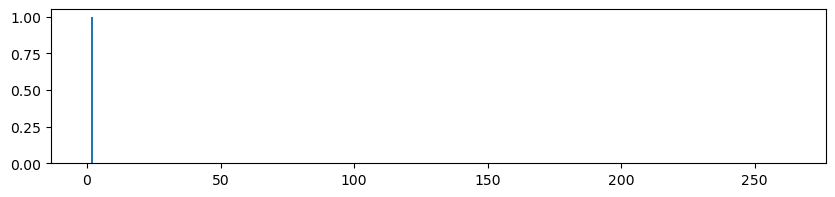

In [34]:
# Let's see if we can work backwards from a classification - in this case, we'll use the frst bird
bird_class = 2 # You can pick a different bird here if you wish
force_class = np.zeros(num_birds)
force_class[bird_class] = 1

print("Here is the forced output of our classification layer (the last Dense layer with Softmax activation)")
# Creating bar chart of Embed layer output values
x = np.arange(num_birds)

fig, ax = plt.subplots(figsize =(10, 2))
ax.bar(x, force_class)

# Show plot
plt.show()

Weights array from the embed layer to the class layer has the shape  (128, 264)
Here is the forced output of our embed layer (the first Dense layer after flattened last Conv layer)


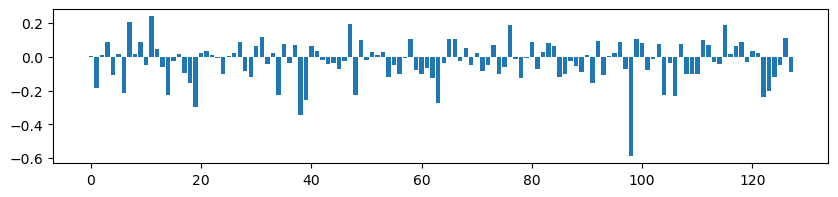

Weights array from the flattened last Conv layer to the embed has the shape  (159744, 128)


In [35]:
# Let's calculate the Embed layer for this forced classification
# Weights from the embed layer to the Classification layer
class_weights = np.copy(model_class.get_layer(index=class_layer).get_weights()[0])
print("Weights array from the embed layer to the class layer has the shape ", class_weights.shape)

num_embed_neurons = class_weights.shape[0]
num_class_neurons = class_weights.shape[1]
embed_data = np.zeros(num_embed_neurons)
for i in range(num_embed_neurons):
    for j in range(num_class_neurons):
        embed_data[i] += force_class[j] * class_weights[i, j]

print("Here is the forced output of our embed layer (the first Dense layer after flattened last Conv layer)")
# Creating bar chart of Embed layer output values
x = np.arange(num_embed_neurons)

fig, ax = plt.subplots(figsize =(10, 2))
ax.bar(x, embed_data)

# Show plot
plt.show()

# Weights from the embed layer to the Flatten-ed last Conv layer
embed_weights = np.copy(model_embed.get_layer(index=embed_layer).get_weights()[0])
print("Weights array from the flattened last Conv layer to the embed has the shape ", embed_weights.shape)

### Work backwards through the NN to recreate a best approximation of the input features, and audio, of the above bird.
* Essentially "What has the NN learned to be the audio feature set for the above bird, and what does it sound like?"

Weights array from the embed layer to the class layer has the shape  (159744, 128)
Weights array shape from the embed layer after undoing the Flatten  (8, 78, 256, 128)
Here is the best approximation of the input for this bird



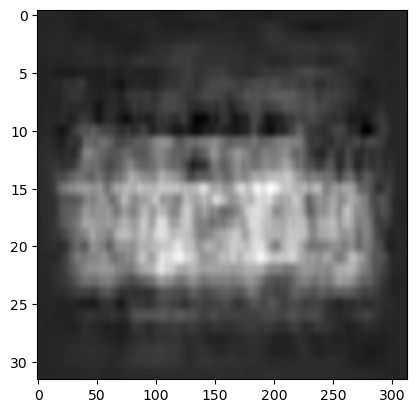

In [36]:
# Let's calculate the last Conv2D layer for this forced classification
# Weights from the last Conv2D layer to the embed layer
last_conv_weights_flat = np.copy(model.get_layer(index=embed_layer).get_weights()[0])
print("Weights array from the embed layer to the class layer has the shape ", last_conv_weights_flat.shape)

last_conv_weights = np.copy(np.reshape(last_conv_weights_flat, pre_flatten))
print("Weights array shape from the embed layer after undoing the Flatten ", last_conv_weights.shape)

# The last convolutional network  is a 3 dimensional arrax of dimensions rows x columns x filters
num_conv_rows = last_conv_weights.shape[0]
num_conv_cols = last_conv_weights.shape[1]
num_conv_filt = last_conv_weights.shape[2]
# In addition, each of these rows x columns x filter outputs is connected to a dense layer with a number of neurons (called the embed layer)
num_embed_neurons = last_conv_weights.shape[3]

# As we build visualizations of each Convolutioal Layer, we cumulatively created "filter patches" that 
# represent all of the prior Convolutional layers as well. Because of this, we don't need to 
# recalculate each layer backwards. We can just use the forward calculated final convolutional layer
# filter patch
last_conv_layer = num_conv - 1
last_filter_patches = filter_patches[last_conv_layer]

# We will use the values of the embed layer (called embed_data here) multiplied by all
# the corresponding weights that connected the last convolutional layer to that embed
# layer (we took care of the "Flatten" above), and those values are the multiplier
# we will apply to each filter patch at the respective location of the recreation.
# In this way, we are moving backwards through the NN; from embed, to last Convolutional
# layer, and finally all the way to a best approximation of the input.
# NOTE: Since we used padding in the forward pass, we'll need to add a border to 
# our workspace input recreation.
border = int(last_filter_patches.shape[0]/2) 
extra_pixels = 2 * border 

# Create the workspace where individual filter patchess will be weighted and added up
conv_data1 = np.zeros((num_conv_rows + extra_pixels, num_conv_cols + extra_pixels))
# add 'em up
for i in range(num_embed_neurons):
    embed_value = embed_data[i] # using local variables to speed things up
    for j in range(num_conv_filt):
        this_filter_patch = last_filter_patches[:,:,j]
        this_conv_to_embed_weights = last_conv_weights[:,:,j,i]
        for k in range(border, num_conv_cols + border, 1):
            for l in range(border, num_conv_rows + border, 1):
                conv_data1[l-border:l+border+1, k-border:k+border+1] += this_filter_patch[:,:] * this_conv_to_embed_weights[l-border,k-border] * embed_value
                
conv_data2 = np.copy(conv_data1)
PIL_image = Image.fromarray(conv_data2)
conv_data = np.array(PIL_image.resize([num_columns, num_rows]))

print("Here is the best approximation of the input for this bird\n")
plt.imshow(conv_data, cmap="gray", aspect=(num_columns/num_rows))


In [37]:
x = model.predict(np.reshape(conv_data, (1, num_rows, num_columns, 1)))

print("As noted above, recreation of input does not mean that recreation will be classified the same way. \n",
      "In fact, using the above as input, the NN categorizes this as bird number ", x.argmax())


1/1 [==============================] - 0s 90ms/step
As noted above, recreation of input does not mean that recreation will be classified the same way. 
 In fact, using the above as input, the NN categorizes this as bird number  245


After scaling, normalized transform has values within this range:  -0.5094022 2.8964167
This is the recreated audio, (un-transformed) hear and see as a graphic file


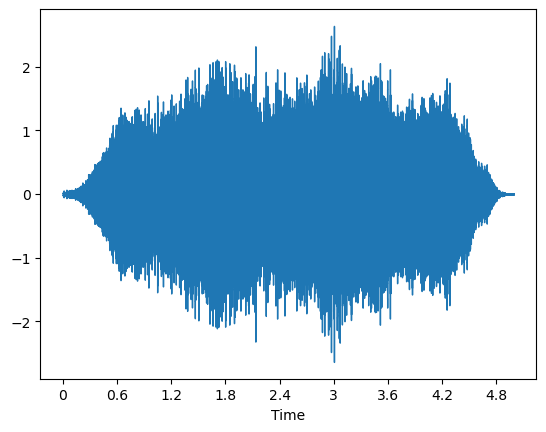

In [38]:
print("After scaling, normalized transform has values within this range: ", conv_data.min(), conv_data.max())
untrans_1 = Domain_to_Audio(conv_data, sr)
print("This is the recreated audio, (un-transformed) hear and see as a graphic file")
librosa.display.waveshow(untrans_1, sr=sr)
IPython.display.Audio(data = untrans_1, rate=sr)

## The above is what the AI "thinks bird class 2 - abythr1 - sounds like."
* Many of the same observations regarding retained vversus discarded information

# Submit the Results
* You will likely run this notebook twice or three times - first to create all the training set images, then to train a NN, and finally to use that trained NN to infer solutions to the contest.
* I have included all of the code - including submission to the contest - to make this easier for you.

Below code modified from "Inferring Birds with Kaggle Models", courtesy PHIL CULLITON +1 · COPIED FROM PRIVATE NOTEBOOK +42,-5 · 1MO AGO · 22,483 VIEWS

In [39]:
def predict_for_sample(filename, sample_submission, frame_limit_secs=None):
    file_id = filename.split(".ogg")[0].split("/")[-1]
    
    audio, sample_rate = librosa.load(filename, sr = sr)
        
    # Get number of samples for 5 seconds
    buffer = segment

    samples_total = len(audio)
    samples_segmented = 0
    counter = 1

    frame = 5

    # this will be a list of 5 second segments
    feature_split = []
    classifications = []

    if num_birds < len(competition_class_map):
        print("Have to append 0% likelihood bird types because only ", num_birds, "were used in taining\n")

    while samples_segmented < samples_total:
        #check if the buffer is not exceeding total samples 
        if buffer > (samples_total - samples_segmented):
            buffer = samples_total - samples_segmented

        block = audio[samples_segmented : (samples_segmented + buffer)]

        # convert the features 
        these_features = Audio_to_Domain(block, sr)

        #scale to 0 - 255
        fmax = these_features.max()
        fmin = these_features.min()
        frange = fmax - fmin
            
        these_features = np.array((((these_features - fmin) / frange)*255))
        feature_split.append(these_features)

        # Classfy each 5 secons segment
        scratch = np.copy(np.reshape(these_features, (1,num_rows, num_columns, 1)))
        scratch2 = (model.predict(scratch, verbose=0))
        classifications.append(scratch2)
        
        counter += 1
        samples_segmented += buffer
                
        probabilities = tf.nn.softmax(scratch2).numpy()
        probabilities = np.copy(np.reshape(probabilities, (num_birds)))
        if num_birds < len(competition_class_map) :
            probabilities = np.append(probabilities, np.zeros(len(competition_class_map) - num_birds))
            print("Had to append bird types because only ", num_birds, "were used in taining")
        print(samples_segmented, samples_total)
        
        ## set the appropriate row in the sample submission
        sample_submission.loc[sample_submission.row_id == file_id + "_" + str(frame), competition_classes] = probabilities[competition_class_map]
        frame += 5
        
def predict_for_sample(filename, sample_submission, frame_limit_secs=None):
    file_id = filename.split(".ogg")[0].split("/")[-1]
    
    audio, sample_rate = librosa.load(filename, sr = sr)
        
    # Get number of samples for 5 seconds
    buffer = segment

    samples_total = len(audio)
    samples_segmented = 0
    counter = 1

    frame = 5

    # this will be a list of 5 second segments
    feature_split = []
    classifications = []

    if num_birds < len(competition_class_map):
        print("Had to append bird types because only ", num_birds, "were used in taining")
    while samples_segmented < samples_total:
        #check if the buffer is not exceeding total samples 
        if buffer > (samples_total - samples_segmented):
            buffer = samples_total - samples_segmented

        block = audio[samples_segmented : (samples_segmented + buffer)]

        # convert the features 
        these_features = Audio_to_Domain(block, sr)

        #scale to 0 - 255
        fmax = these_features.max()
        fmin = these_features.min()
        frange = fmax - fmin
            
        these_features = np.array((((these_features - fmin) / frange)*255))
        feature_split.append(these_features)

        # Classfy each 5 second segment
        scratch = np.copy(np.reshape(these_features, (1, num_rows, num_columns, 1)))
        scratch2 = (model.predict(scratch, verbose = 1))
        classifications.append(scratch2)
        
        counter += 1
        samples_segmented += buffer
                
        probabilities = tf.nn.softmax(scratch2).numpy()
        probabilities = np.copy(np.reshape(probabilities, (num_birds)))
        if num_birds < len(competition_class_map) :
            probabilities = np.append(probabilities, np.zeros(len(competition_class_map) - num_birds))
        # print(samples_segmented, samples_total)
        
        ## set the appropriate row in the sample submission
        sample_submission.loc[sample_submission.row_id == file_id + "_" + str(frame), competition_classes] = probabilities[competition_class_map]
        frame += 5

In [40]:
import glob
test_samples = list(glob.glob("/kaggle/input/birdclef-2023/test_soundscapes/*.ogg"))
test_samples

['/kaggle/input/birdclef-2023/test_soundscapes/soundscape_29201.ogg']

In [41]:
train_metadata = pd.read_csv("/kaggle/input/birdclef-2023/train_metadata.csv")
competition_classes = sorted(train_metadata.primary_label.unique())

competition_class_map = []
for c in competition_classes:
        i = competition_classes.index(c)
        competition_class_map.append(i)
        

sample_sub = pd.read_csv("/kaggle/input/birdclef-2023/sample_submission.csv")
sample_sub[competition_classes] = sample_sub[competition_classes].astype(np.float32)
sample_sub.head()

row_id  abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  \
0   soundscape_29201_5      0.0      0.0      0.0      0.0      0.0      0.0   
1  soundscape_29201_10      0.0      0.0      0.0      0.0      0.0      0.0   
2  soundscape_29201_15      0.0      0.0      0.0      0.0      0.0      0.0   

   affeag1  afgfly1  afghor1  ...  yebsto1  yeccan1  yefcan  yelbis1  yenspu1  \
0      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   
1      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   
2      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   

   yertin1  yesbar1  yespet1  yetgre1  yewgre1  
0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0  

[3 rows x 265 columns]

In [42]:
frame_limit_secs = 15 if sample_sub.shape[0] == 3 else None
for sample_filename in test_samples:
    predict_for_sample(sample_filename, sample_sub, frame_limit_secs=15)

1/1 [==============================] - 0s 106ms/step


In [43]:
sample_sub

row_id   abethr1   abhori1   abythr1   afbfly1   afdfly1  \
0   soundscape_29201_5  0.003769  0.003769  0.003769  0.003769  0.003769   
1  soundscape_29201_10  0.003766  0.003766  0.003766  0.003766  0.003766   
2  soundscape_29201_15  0.003772  0.003772  0.003772  0.003772  0.003772   

    afecuc1   affeag1   afgfly1   afghor1  ...   yebsto1   yeccan1    yefcan  \
0  0.003769  0.003769  0.003769  0.003769  ...  0.003769  0.003769  0.003769   
1  0.003766  0.003766  0.003766  0.003766  ...  0.003766  0.003766  0.003766   
2  0.003772  0.003772  0.003772  0.003772  ...  0.003772  0.003772  0.003772   

    yelbis1   yenspu1   yertin1   yesbar1   yespet1   yetgre1   yewgre1  
0  0.003769  0.003769  0.003769  0.003769  0.003769  0.003769  0.003769  
1  0.003766  0.003766  0.003766  0.003766  0.003766  0.003766  0.003766  
2  0.003772  0.003772  0.003772  0.003772  0.003772  0.003772  0.003772  

[3 rows x 265 columns]

In [44]:
sample_sub.to_csv("submission.csv", index=False)

# Additional Background Information
As you know, in this notebook, we are taking the first step to generate a submission to the [BirdClef2023 competition](https://www.kaggle.com/c/birdclef-2023).  The goal of the competition is to identify Eastern African bird species by sound. 
### "Reading the Robot Mind" is a system that allows non-programmers to examine performance of individual and combined stages of the classification process
Most important for this system is that it can be accomplished by a subject matter expert who may not be familair with the inner workings of AI. Subject matter experts know how to listen to birds and identify them, so they need data presented as audio (and possibly spectral analysis, as I've seen this used extensively by experts when exmining data). Additional references and history of the reading the robot mind system is explained in detail below. 
#### Stages of an automated process to classify birds:
The stages of the desired classification system include:

* A method to record audio (provided with the contest)
* A method of segmenting audio data (somewhat provided with the contest - 5 second segments)
* A method of transforming the audio segment into a sequence of feature vectors (feature extraction such as Mel Scale Frequency Spectrum and MFCC)
* A method of converting sequence of features into an image for CNN processing (in this case, also quantizing to 8-bit unsigned values)
* A method where several CNN (Conv2D) and data reduction (MaxPooling) layers process data in sequence, iteratively extracting salient aspects
* A method of taking a multi-layer CNN and outputting an embedding (Flatten then Dense layer)
* A method of taking the embedding and converting it to a bird classification (Dense with softmax activation)

Prior to the "Reading the Robot Mind" system described herein; a subject matter expert will not be able to examine issues associated with individual stages (such as listening to audio and looking at visualizations) except for the first two stages. Issues that can arise include: Inability to observe the difference between samples from different bird classifications. Inability to observe similarities between samples from the same bird classification. Inability to use audio and visual clues to correctly classify the bird.

This notebook presents a method whereby at any stage of the classification system, the expert can examine the internal workings of the system, and work backwards to audio and visual data in a way that is interpretable by a human expert.
### We will qualitatively examine feature extraction algorithms as part of an effort to "Read the Robot Mind"
This notebook creates a method to allow users to select different hyper-paramenters (methods) at each stage and qualitatively compare them. Variations of segmentation algorithms are not presented in this notebook (since they are dictated to some extent by the rules of this competition).
### Also examined is the Neural Network we trained. Can it too be used to "Read the Robot Mind?"
Here we train a simple NN and see that it can classify with some level of accuracy. We can then use that NN "in reverse" to attempt to recreate an audio signal that generated a particular stage (often referred to as a layer) in the classification.
### Finally - what if we simply supply a classification?
This notebook demonstrates the ability to simply provide the output - and then work backwards through the AI layers and reproduce a best approximation of the input that cause this classification. Effectively asking the AI system to "Let me hear what you've learned a particular bird sounds like."

# Brief History of the "Reading the Robot Mind" System
It used to be that only human experts examined data and made decisions. Now Artificial Intelligence (AI) is enabling robotic decision making in an ever-widening variety of applications. As society allows this to happen, there is a greater likelihood that these robot decisions can affect people’s lives. It makes sense, therefore, to understand the capabilities and societal implications of AI robots.

Big data is a term used to describe both the opportunities and the problems associated with so much information now available for decision making. With the advent of the Internet of Things (IoT) the impact of this huge amount of data is only growing. Actionable decisions need to be distilled from big data and AI can only go so far based on statistical analysis. Because of this, many deep learning algorithms are being developed. 

##  What exactly have these AI robots learned so deeply from all of this big data? 

This question is very reasonable for society to ask. It is not enough to train and create a great AI robot. Many researchers are realizing that before their systems can be deployed, they must be able to prove to human experts that the robots learned the right things from the right data. This is difficult because human expert decision makers are not necessarily the same people who are good at creating robot AI. These two teams must work together in a user friendly way.
## If only we could read the robot mind.
Recently some old research of mine has been getting increased attention by engineers and scientists working on exactly the issues discussed above. This research yielded four US patents and a Windows app that gives a friendly user interface to allow examination of big data and inner workings of a trained AI decision maker. I never publically released the software, called INTEGRAT, because I sold rights to the patents to my employer at the time. 

## Now that the patents have expired, I can share my work.

* For even more details, the reader is directed to the specific patent and independent claims listed below, all publically available at www.USPTO.gov.


# US Patent 5809462
Paul A. Nussbaum, Inventor
## Question: Is the feature extraction algorithm good and can the features be used as a codec?
("codec" is a portmanteau or combination of the words "coder" and "decoder", such as jpeg or mp3, etc...)

All AI systems train on data from the real world gathered by sensors, but before the data can make it to the AI, it must be digitized and important features must be extracted (sometimes called data transformation). "Reading the Robot Mind" allows a human expert to determine if the features extracted have retained sufficient information to identify the correct classification. 

* The question is: does the feature extraction algorithm retain classification-necessary information (or have we thrown away too much information)?

* The premise is as follows: Human experts can observe the original signal and/or measurements and visualizations thereof - and correctly make the classification. 

* The thesis is that: A sufficient condition that the feature extraction algorithm isn't throwing away too much info as it seeks to condition and compress the signal; is that there exists a reverse transformation able to use the extracted features to recreate the original signal and/or measurements and visualizations thereof - such that the human expert will use these to correctly make the classification.

* A bonus is: The human expert can also be presented the extracted features, and may find that they can be useful in future human classification exercises (observedly similar for same classifications, while different from others).

Salient points from US Patent 5809462:

* Independent Claim 1 – Provide a friendly user interface to present the features to the eyes and ears of the human expert to see if they can make the correct decisions based on the transformation features alone.
   
* Independent Claim 14 – Use that same user interface to let the human expert make sure that the data used to train one possible decision all seem similar to each other, and different from data which should yield different decisions.
   
* Independent Claim 25 – Let the human expert see if the features contain enough information to be used as a codec. In other words, if we can transform the original data into a set of features, we should be able to create original data (somewhat distorted and simplified perhaps) from the features – with sufficient information for a human expert to use that to identify the correct decision. 


# US Patent 5867816
Paul A. Nussbaum, Inventor
## Question: Will the robot function just as well when the data segmentation, feature extraction, and decision identifier are fully automated?

The AI Robot is not useful if it requires a human expert to accompany the device when it is deployed in the field for day to day use. The robot must work on its own. Nevertheless, a quality assurance mechanism is required that makes the robot demonstrate it is working in “fully automatic” mode while a human expert grades it on the decisions the AI has made.

* "Reading the Robot Mind" means that this segmentation, feature extraction, and classifier pipeline (inference) are observable in situ (on-site in real deployed situations, preferably live).

* Bonus: The human expert can make adjustments to this pipeline to help get the desired classification accuracy, without requiring technical knowledge of the pipeline.

In the BirdClef2023 

The salient point from US Patent 5867816 is:

* Independent Claims 1, 11, and 29 – The human expert examines and modifies the segmentation, features, and decision identifications to improve automated functioning.


# US Patent 5749066
Paul A. Nussbaum, Inventor
## Question: Is the training data good and can the classifier be used as a codec? 

AI robots can be finicky about the actual examples selected to be used for training. Giving too many of one kind of example can have a negative impact on the resulting decision maker, as can the introduction of misleading data examples (either accidentally or maliciously). Sometimes, a training set can be obviously bad, and other times, only after the AI is trained, can the human expert see that something has gone wrong.
   
* Independent Claims 1 and 7 - Provide a friendly user interface to present all stages of creating the training set to the eyes and ears of the human expert to see if they can spot any problems noted above.

* Independent Claim 3 – Let the human expert see if the AI can be used as a codec. In other words, if the AI can identify the correct decision, then we can work backwards through the AI layers to recreate an exemplary feature set. We can then create the original data (somewhat distorted and simplified perhaps) from those features – with sufficient information for a human expert to use that to identify the correct decision.


#  US Patent 5864803
This Notebook DOES NOT cover these aspects in detail
## Question: How can we assign more than one correct classification when experts cannot agree?
Because data sets can be very large and continuously streaming in from many sources, AI robot creators will chop up the data into segments that can be presented to identify a decision. Sometimes different human experts will see the same data segment and identify different decisions. Similarly, sometimes a human expert will examine one data segment and come up with two possible decisions, each of which are valid. INTEGRAT accounts for this situation in all stages of the creation and testing of the data and the AI robot.
* Independent Claims 1 and 6 - Provide a friendly user interface to present data segments to the human expert and let them change the segmentation algorithm, or manually change a segment, if it could yield more than one decision.
* Independent Claims 13, 17, and 20 – Provide a mechanism whereby multiple “correct” decisions can be assigned to one data segment, as well as AI training algorithms to support this ambiguity. Finally, allow the AI robot to come up with a single “best” decision when presented with ambiguous data, while also alerting users to “second best” decisions, and so on.
